# **RNN (LSTM) Model for Human Action Recognition**

___
___

## **1. INITIALIZATION**

### *1.1. IMPORTS*

In [136]:
from IPython.display import display
from tqdm import tqdm

import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import time

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch
import torch.nn as nn

In [3]:
# to fill the requirement.txt file we use the following line of code:
# import session_info
# session_info.show()

In [50]:
# setting the device as the GPU if available, else the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device: {}".format(device))

device: cuda


### *1.2. DATA LOADING*

In [51]:
data2D_dir = "data/nturgbd60_skeletons_2D/"
data3D_dir = "data/nturgbd60_skeletons_3D/"

data2D_files = os.listdir(data2D_dir)
data3D_files = os.listdir(data3D_dir)

In [52]:
with open("./data/actions.txt", 'r') as actions_file:
    actions = [line.replace('\n', '') for line in actions_file.readlines()]
    actions_file.close()

In [53]:
classes = [5, 6, 7, 8, 14, 24, 30, 32, 42]
for i,elem in enumerate(classes):
    print("class {} : {}".format(i, actions[elem]))

class 0 : pickup
class 1 : throw
class 2 : sitting down
class 3 : standing up (from sitting position)
class 4 : take off jacket
class 5 : reach into pocket
class 6 : pointing to something with finger
class 7 : check time (from watch)
class 8 : falling


In [54]:
class HumanActionDataset2D(Dataset):

    def __init__(self, data_dir, data_files, classes):
        self.data_dir = data_dir
        self.data_files = [data_file for data_file in data_files if int(data_file[17:-4])-1 in classes]
        self.classes = classes

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        tensor = torch.Tensor(np.load(self.data_dir + self.data_files[idx]))
        tensor = tensor.reshape((tensor.shape[0], 50))
        label = self.classes.index(int(self.data_files[idx][17:-4])-1)
        return (tensor, label)

In [55]:
class HumanActionDataset3D(Dataset):

    def __init__(self, data_dir, data_files, classes, with_depth=True):
        self.data_dir = data_dir
        self.data_files = [data_file for data_file in data_files if int(data_file[17:-4])-1 in classes]
        self.classes = classes
        self.with_depth = with_depth

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        tensor = torch.Tensor(np.load(self.data_dir + self.data_files[idx]))
        if self.with_depth:
            tensor = tensor.reshape((tensor.shape[0], 75))
        else:
            tensor = torch.tensor([[tensor[i,k//2,k%2] for k in range(50)] for i in range(tensor.shape[0])])
        label = self.classes.index(int(self.data_files[idx][17:-4])-1)
        return (tensor, label)

In [254]:
HAD2D = HumanActionDataset2D(data2D_dir, data2D_files, classes)
HAD3D = HumanActionDataset3D(data3D_dir, data3D_files, classes)

Here we are going to use PyTorch’s DataLoader with Variable Length Sequences for LSTM/GRU : from this [article](https://www.codefull.net/2018/11/use-pytorchs-dataloader-with-variable-length-sequences-for-lstm-gru/).

In [255]:
class PadSequence():

    def __call__(self, batch):

        # let's assume that each element in "batch" is a tuple (data, label).
        # the following line of code sort the batch in the descending order
        sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
        
        # then we take each sequence of the batch and pad it
        sequences = [x[0] for x in sorted_batch]
        sequences_padded_end = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)

        lengths = torch.LongTensor([len(x) for x in sequences])

        # here we adjust the padding because we want zeros at the beginning
        # (we had poor results with zeros at the end)
        sequences_padded_begin = torch.stack(
            [torch.cat([
                sequences_padded_end[i][lengths[i]:],
                sequences_padded_end[i][:lengths[i]]]
            ) for i in range(len(sequences_padded_end))]
        )

        # don't forget to grab the labels of the *sorted* batch
        labels = torch.LongTensor([x[1] for x in sorted_batch])
        return sequences_padded_begin, lengths, labels

We use 80% of the data for training and the remaining 20% for validation.

In [256]:
train_dataset2D, val_dataset2D = torch.utils.data.random_split(HAD2D, [int(0.80*len(HAD2D)), len(HAD2D)-int(0.80*len(HAD2D))])
train_dataset3D, val_dataset3D = torch.utils.data.random_split(HAD3D, [int(0.80*len(HAD3D)), len(HAD3D)-int(0.80*len(HAD3D))])

train_dataloader2D = torch.utils.data.DataLoader(dataset=train_dataset2D, batch_size=32, collate_fn=PadSequence(), shuffle=True)
val_dataloader2D = torch.utils.data.DataLoader(dataset=val_dataset2D, batch_size=32, collate_fn=PadSequence(), shuffle=True)

train_dataloader3D = torch.utils.data.DataLoader(dataset=train_dataset3D, batch_size=32, collate_fn=PadSequence(), shuffle=True)
val_dataloader3D = torch.utils.data.DataLoader(dataset=val_dataset3D, batch_size=32, collate_fn=PadSequence(), shuffle=True)

### *1.3 AUXILIARY FUNCTIONS*

In [59]:
def train_model(model, criterion, optimizer, nb_epochs, epoch_print_frequence, train_dataset, val_dataset, train_dataloader, val_dataloader):

    s = time.time()

    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    sm = nn.Softmax(dim=1).to(device)

    for epoch in range(nb_epochs):
        
        running_loss_train, running_loss_val, running_acc_train, running_acc_val = 0, 0, 0, 0

        for train in [True, False]:

            if train:
                dataloader = train_dataloader
                model.train()
            
            else:
                dataloader = val_dataloader
                model.eval()

            for data in dataloader:
                
                inputs = data[0].to(device)
                labels = torch.zeros((inputs.shape[0], len(classes)))
                for i in range(inputs.shape[0]):
                    labels[i][int(data[-1][i])] = 1
                labels = labels.to(device)

                if train:
                    optimizer.zero_grad()

                outputs_for_loss,_,_ = model(inputs)
                
                outputs = sm(outputs_for_loss).to(device)
                loss = criterion(outputs_for_loss, labels)

                if train:
                    loss.backward()
                    optimizer.step()
                    running_loss_train += loss.item()
                    running_acc_train += int(torch.sum(outputs.argmax(dim=1) == labels.argmax(dim=1)))
                else:
                    running_loss_val += loss.item()
                    running_acc_val += int(torch.sum(outputs.argmax(dim=1) == labels.argmax(dim=1)))

        running_loss_train /= len(train_dataloader)
        running_loss_val /= len(val_dataloader)
        running_acc_train /= len(train_dataset)
        running_acc_val /= len(val_dataset)

        train_losses.append(running_loss_train)
        val_losses.append(running_loss_val)
        train_accs.append(running_acc_train)
        val_accs.append(running_acc_val)

        if (epoch+1) % epoch_print_frequence == 0:
            print("epochs {} ({} s) | train loss : {} | val loss : {} | train acc : {} | val acc : {}".format(
                epoch+1,
                int(time.time()-s),
                running_loss_train,
                running_loss_val,
                running_acc_train,
                running_acc_val
            ))
    
    return train_losses, val_losses, train_accs, val_accs

___

## **2. BUILDING THE MODEL (3D DATA) :** DATASET INFLUENCE

### *2.1. Definition of the models' architecture*

In this notebook we will only consider the following model and only change the training dataset.

In [145]:
class LSTM03D(nn.Module):

    def __init__(self, nb_classes, input_size, hidden_size_lstm, hidden_size_classifier, num_layers, device):

        super(LSTM03D, self).__init__()

        self.num_classes = nb_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size_lstm
        self.device = device

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size_lstm, num_layers=num_layers, batch_first=True) # lstm
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size_lstm, hidden_size_classifier),
            nn.ReLU(),
            nn.Linear(hidden_size_classifier, nb_classes)
        )

    def forward(self,x,h_0=None,c_0=None):
        if h_0 is None:
            h_0 = torch.rand(self.num_layers, x.size(0), self.hidden_size).to(self.device) # hidden state (short memory)
            c_0 = torch.rand(self.num_layers, x.size(0), self.hidden_size).to(self.device) # internal state (long memory)
        _, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        h_n_reshape = h_n[-1].reshape(1, h_n.shape[1], h_n.shape[2]).view(-1, self.hidden_size)
        results = self.classifier(h_n_reshape) # reshaping the data for clasifier
        return results, h_n, c_n

### *2.2. Training*

#### *2.2.A On Raw Data (Without Data Augmentation & Masking)*

In [61]:
model_LSTM03D = LSTM03D(nb_classes=len(classes), input_size=75, hidden_size_lstm=256, hidden_size_classifier=128, num_layers=1, device=device)
model_LSTM03D.to(device)
model_LSTM03D.eval()

LSTM03D(
  (lstm): LSTM(75, 256, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=9, bias=True)
  )
)

In [62]:
criterion_LSTM03D = nn.CrossEntropyLoss()
optimizer_LSTM03D = torch.optim.Adam(params=model_LSTM03D.parameters(), lr=1e-4)
lr_scheduler_LSTM03D = torch.optim.lr_scheduler.StepLR(optimizer_LSTM03D, step_size=10, gamma=0.1)

Let's train and save this first model and see the evolution of the loss and accuracy over the epochs.

In [63]:
nb_epochs = 200
epoch_print_frequence = 10

In [64]:
if False:
    losses_accs_LSTM03D = train_model(model_LSTM03D, criterion_LSTM03D, optimizer_LSTM03D, nb_epochs, epoch_print_frequence, train_dataloader3D, val_dataloader3D)
    torch.save(model_LSTM03D.state_dict(), "./models_saved/LSTM03D.pt")

else:

    print("\
        epochs  10 (  95 s) | train loss : 0.503461534428 | val loss : 0.488015889535 | train acc : 0.820524146054 | val acc : 0.824602707474\n\
        epochs  50 ( 452 s) | train loss : 0.173727466939 | val loss : 0.252250215625 | train acc : 0.936690223792 | val acc : 0.914067098293\n\
        epochs 100 ( 942 s) | train loss : 0.067918642642 | val loss : 0.206346011837 | train acc : 0.975853945818 | val acc : 0.941730429664\n\
        epochs 150 (1457 s) | train loss : 0.023558179162 | val loss : 0.266941844760 | train acc : 0.993080094228 | val acc : 0.939376103590\n\
        epochs 200 (1973 s) | train loss : 0.006287749795 | val loss : 0.247811991190 | train acc : 0.998674911660 | val acc : 0.944673337257")

        epochs  10 (  95 s) | train loss : 0.503461534428 | val loss : 0.488015889535 | train acc : 0.820524146054 | val acc : 0.824602707474
        epochs  50 ( 452 s) | train loss : 0.173727466939 | val loss : 0.252250215625 | train acc : 0.936690223792 | val acc : 0.914067098293
        epochs 100 ( 942 s) | train loss : 0.067918642642 | val loss : 0.206346011837 | train acc : 0.975853945818 | val acc : 0.941730429664
        epochs 150 (1457 s) | train loss : 0.023558179162 | val loss : 0.266941844760 | train acc : 0.993080094228 | val acc : 0.939376103590
        epochs 200 (1973 s) | train loss : 0.006287749795 | val loss : 0.247811991190 | train acc : 0.998674911660 | val acc : 0.944673337257


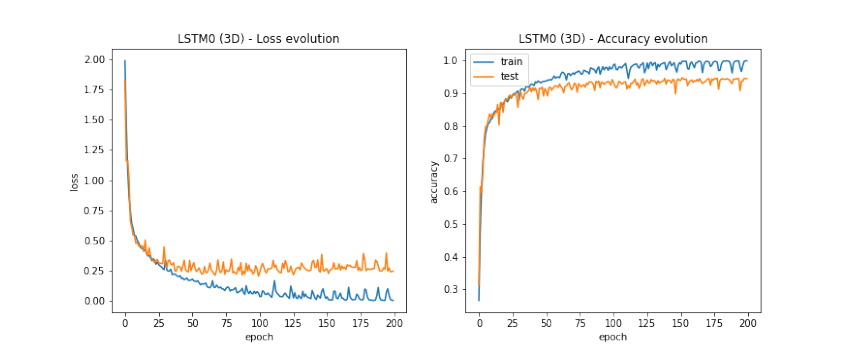

In [65]:
if False:
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

    ax[0].set(title="LSTM0 (3D) - Loss evolution")
    ax[0].plot(losses_accs_LSTM03D[0], label="train")
    ax[0].plot(losses_accs_LSTM03D[1], label="test")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")

    ax[1].set(title="LSTM0 (3D) - Accuracy evolution")
    ax[1].plot(losses_accs_LSTM03D[2], label="train")
    ax[1].plot(losses_accs_LSTM03D[3], label="test")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("accuracy")

    plt.legend()
    plt.savefig("./models_saved/LSTM03D_loss_acc.png")
    plt.show()

else:

    img = plt.imread("./models_saved/LSTM03D_loss_acc.png")
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    plt.axis("off")

In [66]:
model_LSTM03D = LSTM03D(nb_classes=len(classes), input_size=75, hidden_size_lstm=256, hidden_size_classifier=128, num_layers=1, device=device)
model_LSTM03D.to(device)
model_LSTM03D.load_state_dict(torch.load("./models_saved/LSTM03D.pt"))
model_LSTM03D.eval()

LSTM03D(
  (lstm): LSTM(75, 256, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=9, bias=True)
  )
)

#### *2.2.B On Masked Data*

As a reminder:

![skeleton](./assets/skeleton.png)

In [67]:
class HumanActionDataset3D_masked(Dataset):

    def __init__(self, data_dir, data_files, classes, masked_percentage=0, max_hide=0):
        self.data_dir = data_dir
        self.data_files = [data_file for data_file in data_files if int(data_file[17:-4])-1 in classes]
        self.classes = classes
        self.masked_percentage = masked_percentage # chance to have some body parts hide
        self.max_hide = max(0, min(max_hide,25)) # maximum number of body parts to hide

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        tensor = torch.Tensor(np.load(self.data_dir + self.data_files[idx]))
        if np.random.random() < self.masked_percentage:
            nb_to_hide = np.random.randint(low=1, high=self.max_hide+1)
            parts_to_hide = np.random.choice(a=25, size=nb_to_hide, replace=False)
            for part_to_hide in parts_to_hide:
                tensor[:,part_to_hide,:] = -100
        tensor = tensor.reshape((tensor.shape[0], tensor.shape[1]*tensor.shape[2]))
        label = self.classes.index(int(self.data_files[idx][17:-4])-1)
        return (tensor, label)

In [68]:
HAD3D_masked = HumanActionDataset3D_masked(data3D_dir, data3D_files, classes, masked_percentage=0.25, max_hide=10)

In [69]:
train_dataset3D_masked, val_dataset3D_masked = torch.utils.data.random_split(HAD3D_masked, [int(0.80*len(HAD3D_masked)), len(HAD3D_masked)-int(0.80*len(HAD3D_masked))])

train_dataloader3D_masked = torch.utils.data.DataLoader(dataset=train_dataset3D_masked, batch_size=32, collate_fn=PadSequence(), shuffle=True)
val_dataloader3D_masked = torch.utils.data.DataLoader(dataset=val_dataset3D_masked, batch_size=32, collate_fn=PadSequence(), shuffle=True)

In [70]:
# we use the model trained previously as a base (thus we have a pretrained model)
model_LSTM03D_masked = LSTM03D(nb_classes=len(classes), input_size=75, hidden_size_lstm=256, hidden_size_classifier=128, num_layers=1, device=device)
model_LSTM03D_masked.to(device)
model_LSTM03D_masked.load_state_dict(torch.load("./models_saved/LSTM03D.pt"))
model_LSTM03D_masked.eval()

LSTM03D(
  (lstm): LSTM(75, 256, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=9, bias=True)
  )
)

In [71]:
criterion_LSTM03D_masked = nn.CrossEntropyLoss()
optimizer_LSTM03D_masked = torch.optim.Adam(params=model_LSTM03D_masked.parameters(), lr=1e-4)
lr_scheduler_LSTM03D_masked = torch.optim.lr_scheduler.StepLR(optimizer_LSTM03D_masked, step_size=10, gamma=0.1)

In [72]:
nb_epochs = 400
epoch_print_frequence = 40

In [73]:
if False:
    losses_accs_LSTM03D_masked = train_model(model_LSTM03D_masked, criterion_LSTM03D_masked, optimizer_LSTM03D_masked, nb_epochs, epoch_print_frequence, train_dataloader3D_masked, val_dataloader3D_masked)
    torch.save(model_LSTM03D_masked.state_dict(), "./models_saved/LSTM03Dmasked.pt")

else:

    print("\
        epochs  40 ( 977 s) | train loss : 0.498529010885 | val loss : 0.572103275469 | train acc : 0.810365135453 | val acc : 0.7816362566215\n\
        epochs 120 (2106 s) | train loss : 0.205803418523 | val loss : 0.301278640826 | train acc : 0.923586572438 | val acc : 0.8887580929958\n\
        epochs 200 (3202 s) | train loss : 0.144118087777 | val loss : 0.279601403115 | train acc : 0.945965842167 | val acc : 0.9134785167745\n\
        epochs 240 (3688 s) | train loss : 0.129586402714 | val loss : 0.255482562852 | train acc : 0.952444051825 | val acc : 0.9199529134785\n\
        epochs 320 (4713 s) | train loss : 0.103079808074 | val loss : 0.296544183632 | train acc : 0.965106007067 | val acc : 0.9270158917010\n\
        epochs 400 (5830 s) | train loss : 0.086584374245 | val loss : 0.253362386861 | train acc : 0.967461719670 | val acc : 0.9276044732195")

        epochs  40 ( 977 s) | train loss : 0.498529010885 | val loss : 0.572103275469 | train acc : 0.810365135453 | val acc : 0.7816362566215
        epochs 120 (2106 s) | train loss : 0.205803418523 | val loss : 0.301278640826 | train acc : 0.923586572438 | val acc : 0.8887580929958
        epochs 200 (3202 s) | train loss : 0.144118087777 | val loss : 0.279601403115 | train acc : 0.945965842167 | val acc : 0.9134785167745
        epochs 240 (3688 s) | train loss : 0.129586402714 | val loss : 0.255482562852 | train acc : 0.952444051825 | val acc : 0.9199529134785
        epochs 320 (4713 s) | train loss : 0.103079808074 | val loss : 0.296544183632 | train acc : 0.965106007067 | val acc : 0.9270158917010
        epochs 400 (5830 s) | train loss : 0.086584374245 | val loss : 0.253362386861 | train acc : 0.967461719670 | val acc : 0.9276044732195


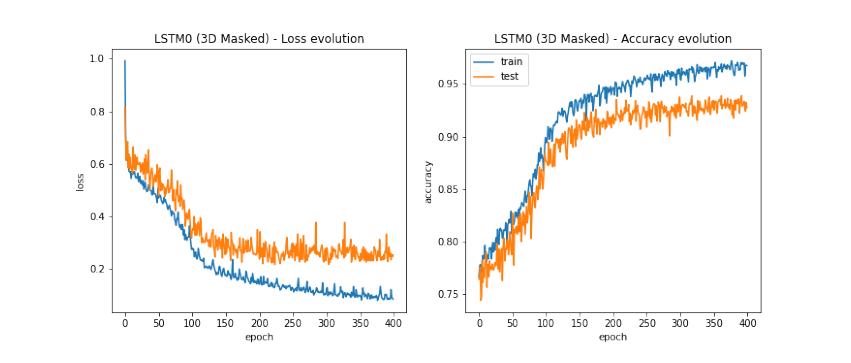

In [74]:
if False:
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

    ax[0].set(title="LSTM0 (3D Masked) - Loss evolution")
    ax[0].plot(losses_accs_LSTM03D_masked[0], label="train")
    ax[0].plot(losses_accs_LSTM03D_masked[1], label="test")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")

    ax[1].set(title="LSTM0 (3D Masked) - Accuracy evolution")
    ax[1].plot(losses_accs_LSTM03D_masked[2], label="train")
    ax[1].plot(losses_accs_LSTM03D_masked[3], label="test")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("accuracy")

    plt.legend()
    plt.savefig("./models_saved/LSTM03Dmasked_loss_acc.png")
    plt.show()

else:

    img = plt.imread("./models_saved/LSTM03Dmasked_loss_acc.png")
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    plt.axis("off")

In [75]:
model_LSTM03D_masked = LSTM03D(nb_classes=len(classes), input_size=75, hidden_size_lstm=256, hidden_size_classifier=128, num_layers=1, device=device)
model_LSTM03D_masked.to(device)
model_LSTM03D_masked.load_state_dict(torch.load("./models_saved/LSTM03Dmasked.pt"))
model_LSTM03D_masked.eval()

LSTM03D(
  (lstm): LSTM(75, 256, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=9, bias=True)
  )
)

#### *2.2.B On Part of the sequences*

In [76]:
class HumanActionDataset3D_part(Dataset):

    def __init__(self, data_dir, data_files, classes, min_percentage=1):
        self.data_dir = data_dir
        self.data_files = [data_file for data_file in data_files if int(data_file[17:-4])-1 in classes]
        self.classes = classes
        self.min_percentage = max(0,min(min_percentage,1))

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        tensor = torch.Tensor(np.load(self.data_dir + self.data_files[idx]))
        if self.min_percentage < 1:
            percentage = np.random.randint(low=int(100*self.min_percentage), high=100)/100
            max_length = int(percentage * tensor.shape[0])
            tensor = tensor[:max_length,:,:]
        tensor = tensor.reshape((tensor.shape[0], tensor.shape[1]*tensor.shape[2]))
        label = self.classes.index(int(self.data_files[idx][17:-4])-1)
        return (tensor, label)

In [77]:
HAD3D_part = HumanActionDataset3D_part(data3D_dir, data3D_files, classes, min_percentage=0.1)

In [78]:
train_dataset3D_part, val_dataset3D_part = torch.utils.data.random_split(HAD3D_part, [int(0.80*len(HAD3D_part)), len(HAD3D_part)-int(0.80*len(HAD3D_part))])

train_dataloader3D_part = torch.utils.data.DataLoader(dataset=train_dataset3D_part, batch_size=32, collate_fn=PadSequence(), shuffle=True)
val_dataloader3D_part = torch.utils.data.DataLoader(dataset=val_dataset3D_part, batch_size=32, collate_fn=PadSequence(), shuffle=True)

In [79]:
# we use the model trained previously as a base (thus we have a pretrained model)
model_LSTM03D_part = LSTM03D(nb_classes=len(classes), input_size=75, hidden_size_lstm=256, hidden_size_classifier=128, num_layers=1, device=device)
model_LSTM03D_part.to(device)
model_LSTM03D_part.load_state_dict(torch.load("./models_saved/LSTM03D.pt"))
model_LSTM03D_part.eval()

LSTM03D(
  (lstm): LSTM(75, 256, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=9, bias=True)
  )
)

In [80]:
criterion_LSTM03D_part = nn.CrossEntropyLoss()
optimizer_LSTM03D_part = torch.optim.Adam(params=model_LSTM03D_part.parameters(), lr=1e-4)
lr_scheduler_LSTM03D_part = torch.optim.lr_scheduler.StepLR(optimizer_LSTM03D_part, step_size=10, gamma=0.1)

In [81]:
nb_epochs = 200
epoch_print_frequence = 10

In [82]:
if False:
    losses_accs_LSTM03D_part = train_model(model_LSTM03D_part, criterion_LSTM03D_part, optimizer_LSTM03D_part, nb_epochs, epoch_print_frequence, train_dataloader3D_part, val_dataloader3D_part)
    torch.save(model_LSTM03D_part.state_dict(), "./models_saved/LSTM03Dpart.pt")

else:

    print("\
        epochs  10 (  89 s) | train loss : 0.835141547269 | val loss : 0.8588088011300 | train acc : 0.692137809187 | val acc : 0.686874632136\n\
        epochs  50 ( 471 s) | train loss : 0.624624993039 | val loss : 0.7649451014068 | train acc : 0.763839811542 | val acc : 0.731018246027\n\
        epochs 100 (1021 s) | train loss : 0.524252282132 | val loss : 0.7796561408925 | train acc : 0.800942285041 | val acc : 0.730429664508\n\
        epochs 150 (1664 s) | train loss : 0.460821043752 | val loss : 0.7671710341065 | train acc : 0.827296819787 | val acc : 0.746909947027\n\
        epochs 200 (2272 s) | train loss : 0.418173704803 | val loss : 0.7916647537990 | train acc : 0.838191990577 | val acc : 0.750441436138")

        epochs  10 (  89 s) | train loss : 0.835141547269 | val loss : 0.8588088011300 | train acc : 0.692137809187 | val acc : 0.686874632136
        epochs  50 ( 471 s) | train loss : 0.624624993039 | val loss : 0.7649451014068 | train acc : 0.763839811542 | val acc : 0.731018246027
        epochs 100 (1021 s) | train loss : 0.524252282132 | val loss : 0.7796561408925 | train acc : 0.800942285041 | val acc : 0.730429664508
        epochs 150 (1664 s) | train loss : 0.460821043752 | val loss : 0.7671710341065 | train acc : 0.827296819787 | val acc : 0.746909947027
        epochs 200 (2272 s) | train loss : 0.418173704803 | val loss : 0.7916647537990 | train acc : 0.838191990577 | val acc : 0.750441436138


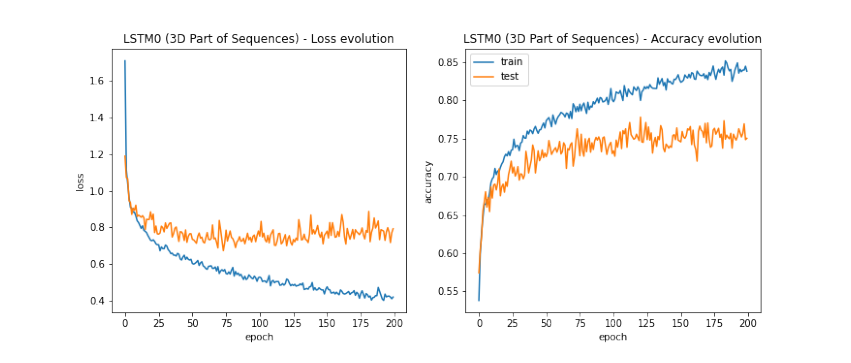

In [83]:
if False:
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

    ax[0].set(title="LSTM0 (3D Part of Sequences) - Loss evolution")
    ax[0].plot(losses_accs_LSTM03D_part[0], label="train")
    ax[0].plot(losses_accs_LSTM03D_part[1], label="test")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")

    ax[1].set(title="LSTM0 (3D Part of Sequences) - Accuracy evolution")
    ax[1].plot(losses_accs_LSTM03D_part[2], label="train")
    ax[1].plot(losses_accs_LSTM03D_part[3], label="test")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("accuracy")

    plt.legend()
    plt.savefig("./models_saved/LSTM03Dpart_loss_acc.png")
    plt.show()

else:

    img = plt.imread("./models_saved/LSTM03Dpart_loss_acc.png")
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    plt.axis("off")

In [84]:
model_LSTM03D_part = LSTM03D(nb_classes=len(classes), input_size=75, hidden_size_lstm=256, hidden_size_classifier=128, num_layers=1, device=device)
model_LSTM03D_part.to(device)
model_LSTM03D_part.load_state_dict(torch.load("./models_saved/LSTM03Dpart.pt"))
model_LSTM03D_part.eval()

LSTM03D(
  (lstm): LSTM(75, 256, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=9, bias=True)
  )
)

### *2.3. Evaluate the models*

#### *2.3.A. Accuracy on full sequences*

In [85]:
def accuracy_on_full_sequence(models, dataset):

    accuracies_per_model = np.zeros((len(models),len(classes)))
    n = len(dataset)
    sm = nn.Softmax(dim=1).to(device)

    N = np.zeros(len(classes))

    for i in tqdm(range(n)):

        tensor,label = dataset[i]
        tensor = tensor.to(device)
        tensor = tensor.reshape(1,tensor.shape[0],75)
        N[label] += 1

        for k,model in enumerate(models):

            accuracies_per_model[k][label] += int(sm(model(tensor)[0]).argmax().item()==label)
    
    for j in range(len(classes)):
        accuracies_per_model[:,j] = accuracies_per_model[:,j] / N[j]

    return accuracies_per_model

In [86]:
if False:
    train_results_per_model = accuracy_on_full_sequence([model_LSTM03D, model_LSTM03D_masked, model_LSTM03D_part], train_dataset3D)
    val_results_per_model = accuracy_on_full_sequence([model_LSTM03D, model_LSTM03D_masked, model_LSTM03D_part], val_dataset3D)

In [87]:
if False:
    
    train_data_per_model = {"basic model": train_results_per_model[0], "masked model": train_results_per_model[1], "part model": train_results_per_model[2]}
    train_df = pd.DataFrame(train_data_per_model).transpose()
    train_df.columns = ["class {}".format(i) for i in range(train_results_per_model.shape[1])]
    train_df["average"] = np.average(train_results_per_model, axis=1)
    print("ON TRAINSET")
    display(train_df)

    val_data_per_model = {"basic model": val_results_per_model[0], "masked model": val_results_per_model[1], "part model": val_results_per_model[2]}
    val_df = pd.DataFrame(val_data_per_model).transpose()
    val_df.columns = ["class {}".format(i) for i in range(val_results_per_model.shape[1])]
    val_df["average"] = np.average(val_results_per_model, axis=1)
    print("ON VALSET")
    display(val_df)

else:

    print("ON TRAINSET\n\
                     | class 0 | class 1 | class 2 | class 3 | class 4 | class 5 | class 6 | class 7 | class 8 | average\n\
        ----------------------------------------------------------------------------------------------------------------\n\
        basic  model |   0.996 |   0.985 |   0.992 |   0.987 |   0.986 |   0.971 |   0.977 |   0.968 |   0.992 |   0.983\n\
        masked model |   0.981 |   0.956 |   0.960 |   0.968 |   0.989 |   0.969 |   0.952 |   0.943 |   0.943 |   0.962\n\
        part   model |   0.979 |   0.952 |   0.981 |   0.975 |   0.992 |   0.952 |   0.928 |   0.883 |   0.971 |   0.957\n\n")

    print("ON VALSET\n\
                     | class 0 | class 1 | class 2 | class 3 | class 4 | class 5 | class 6 | class 7 | class 8 | average\n\
        ----------------------------------------------------------------------------------------------------------------\n\
        basic  model |   0.984 |   0.984 |   0.957 |   1.000 |   0.986 |   0.977 |   0.979 |   0.985 |   0.997 |   0.987\n\
        masked model |   0.989 |   0.963 |   0.941 |   0.981 |   0.981 |   0.983 |   0.944 |   0.961 |   0.968 |   0.968\n\
        part   model |   0.989 |   0.932 |   0.984 |   0.969 |   0.995 |   0.966 |   0.913 |   0.897 |   0.973 |   0.958")

ON TRAINSET
                     | class 0 | class 1 | class 2 | class 3 | class 4 | class 5 | class 6 | class 7 | class 8 | average
        ----------------------------------------------------------------------------------------------------------------
        basic  model |   0.996 |   0.985 |   0.992 |   0.987 |   0.986 |   0.971 |   0.977 |   0.968 |   0.992 |   0.983
        masked model |   0.981 |   0.956 |   0.960 |   0.968 |   0.989 |   0.969 |   0.952 |   0.943 |   0.943 |   0.962
        part   model |   0.979 |   0.952 |   0.981 |   0.975 |   0.992 |   0.952 |   0.928 |   0.883 |   0.971 |   0.957


ON VALSET
                     | class 0 | class 1 | class 2 | class 3 | class 4 | class 5 | class 6 | class 7 | class 8 | average
        ----------------------------------------------------------------------------------------------------------------
        basic  model |   0.984 |   0.984 |   0.957 |   1.000 |   0.986 |   0.977 |   0.979 |   0.985 |   0.997 |   0.987
        

* As expected the basic model perform betters on full sequences (98% of accuracy on both trainset and valset)
* But the two other models are really close

#### *2.3.B. Accuracy on masked sequences*

In [88]:
def accuracy_per_masked_percentage(models, dataset, action_class, min_percentage=0, max_percentage=0.99, steps=10):
    
    percentages = np.linspace(start=min_percentage, stop=max_percentage, num=steps)
    accuracies_per_model = [[]] * len(models)
    n = len(dataset)
    sm = nn.Softmax(dim=1).to(device)

    N = sum([dataset[i][1] == action_class for i in range(n)])
    
    for i in tqdm(range(len(percentages))):

        percentage = 1-percentages[i]
        
        accuracies = np.zeros(len(models))

        for it in range(3):
        
            for j in range(n):
                
                tensor,label = dataset[j]

                if label == action_class:

                    nb_to_hide = int(percentage*25)
                    if nb_to_hide > 0:
                        parts_to_hide = np.random.choice(a=25, size=nb_to_hide, replace=False)
                        for part_to_hide in parts_to_hide:
                                tensor[:,part_to_hide] = -10
                    
                    tensor = tensor.to(device)
                    tensor = tensor.reshape(1,tensor.shape[0],75)
                    
                    for k,model in enumerate(models):

                        accuracies[k] += int(sm(model(tensor)[0]).argmax().item()==label)
        
        for k in range(len(models)):

            accuracies_per_model[k] = accuracies_per_model[k] + [accuracies[k]/(3*N)]

    return accuracies_per_model

In [89]:
if False:
    
    train_results_per_masked_percentage = [
        accuracy_per_masked_percentage([model_LSTM03D, model_LSTM03D_masked, model_LSTM03D_part], train_dataset3D, action_class=elem) for elem in range(len(classes))
    ]

    val_results_per_masked_percentage = [
        accuracy_per_masked_percentage([model_LSTM03D, model_LSTM03D_masked, model_LSTM03D_part], val_dataset3D, action_class=elem) for elem in range(len(classes))
    ]

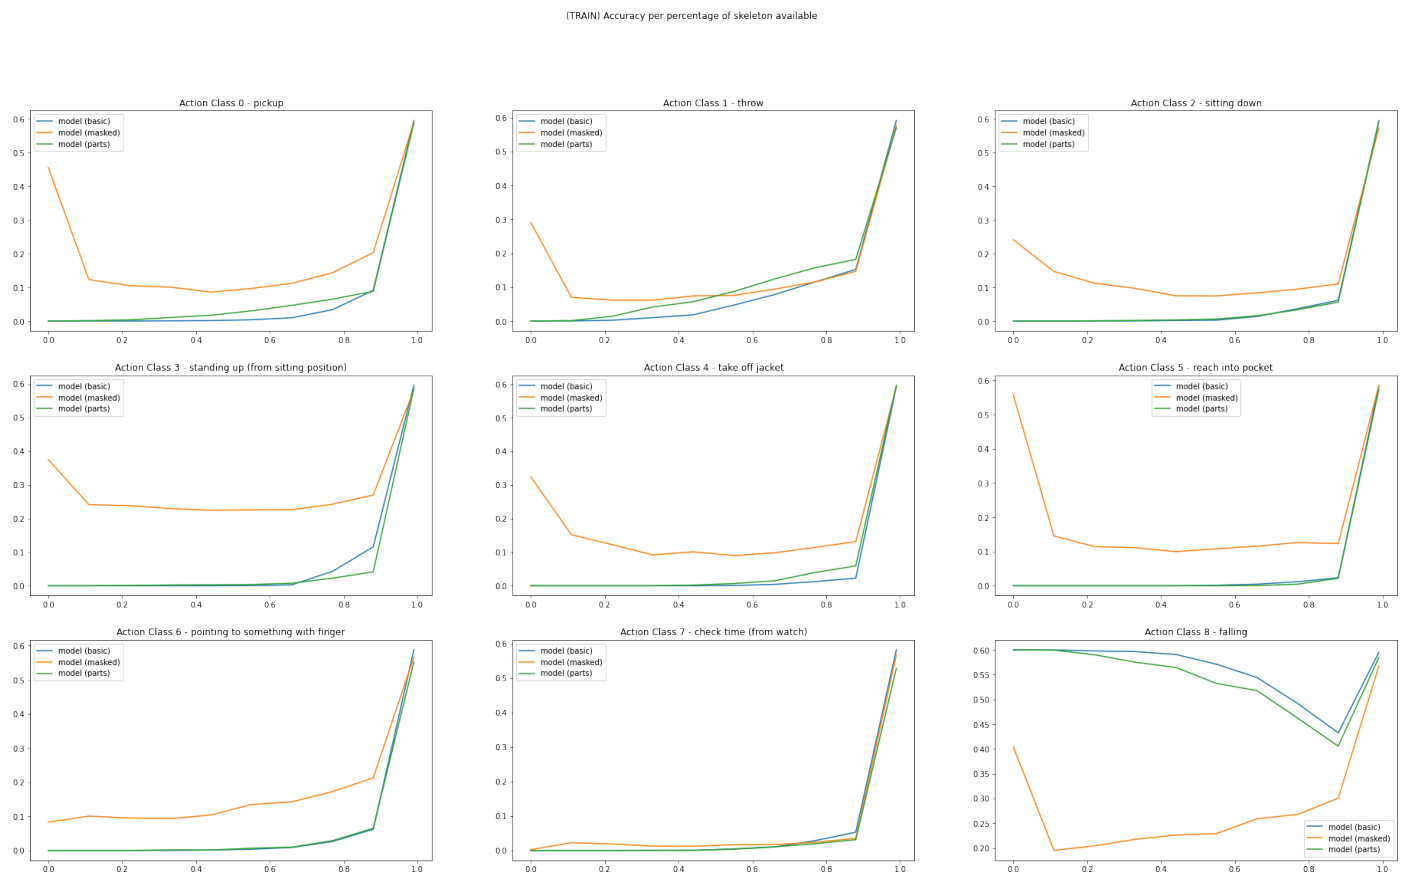

In [90]:
if False:
    
    plt.clf()

    fig, ax = plt.subplots(nrows=3, ncols=3)
    fig.set_figheight(18)
    fig.set_figwidth(32)

    x = np.linspace(start=0.0, stop=0.99, num=10)

    for i in range(len(classes)):

        ax[i//3][i%3].set_title("Action Class {} - {}".format(i, actions[classes[i]]))
        accuracies = train_results_per_masked_percentage[i]
        ax[i//3][i%3].plot(x, accuracies[0], label="model (basic)")
        ax[i//3][i%3].plot(x, accuracies[1], label="model (masked)")
        ax[i//3][i%3].plot(x, accuracies[2], label="model (parts)")
        ax[i//3][i%3].legend()

    fig.suptitle("(TRAIN) Accuracy per percentage of skeleton available")
    plt.savefig("./assets/acc_per_skeleton_percentage_train.png")
    plt.show()

else:

    img = plt.imread("./assets/acc_per_skeleton_percentage_train.png")
    plt.figure(figsize=(25,32))
    plt.imshow(img)
    plt.axis("off")

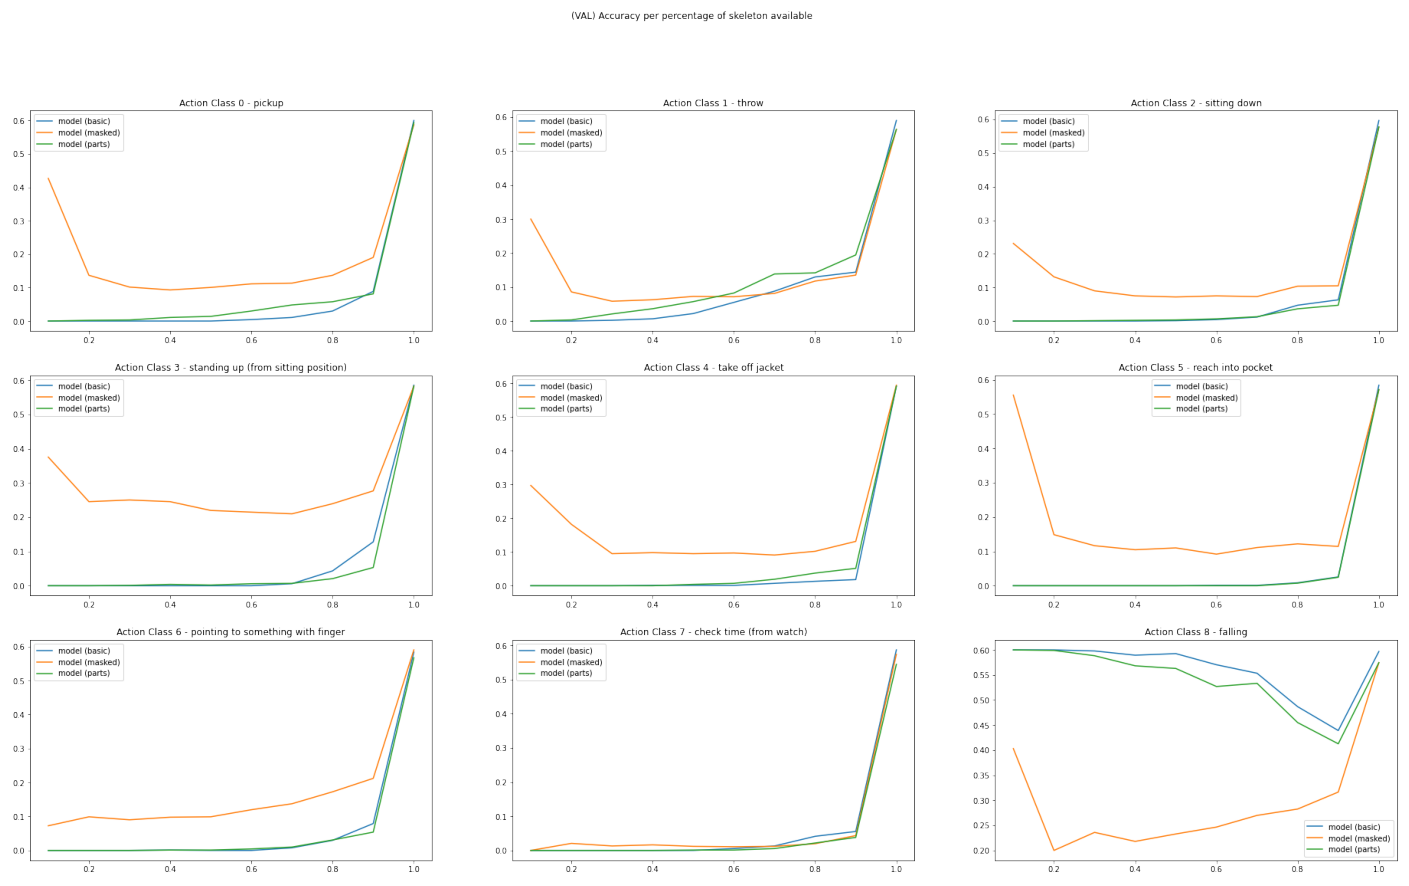

In [91]:
if False:
    
    plt.clf()

    fig, ax = plt.subplots(nrows=3, ncols=3)
    fig.set_figheight(18)
    fig.set_figwidth(32)

    x = np.linspace(start=0.1, stop=1, num=10)

    for i in range(len(classes)):

        ax[i//3][i%3].set_title("Action Class {} - {}".format(i, actions[classes[i]]))
        accuracies = val_results_per_masked_percentage[i]
        ax[i//3][i%3].plot(x, accuracies[0], label="model (basic)")
        ax[i//3][i%3].plot(x, accuracies[1], label="model (masked)")
        ax[i//3][i%3].plot(x, accuracies[2], label="model (parts)")
        ax[i//3][i%3].legend()

    fig.suptitle("(VAL) Accuracy per percentage of skeleton available")
    plt.savefig("./assets/acc_per_skeleton_percentage_val.png")
    plt.show()

else:

    img = plt.imread("./assets/acc_per_skeleton_percentage_val.png")
    plt.figure(figsize=(25,32))
    plt.imshow(img)
    plt.axis("off")

* Unsatisfying results
* The masked model is better but not by far
* Some predictions are random (I think) when the number of joints available is too high.

#### *2.3.C. Accuracy on part of the sequences*

In [305]:
def accuracy_per_sequence_percentage(models, dataset, action_class, min_percentage=0.1, max_percentage=1, steps=10):
    
    percentages = np.linspace(start=min_percentage, stop=max_percentage, num=steps)
    accuracies_per_model = [[]] * len(models)
    n = len(dataset)
    sm = nn.Softmax(dim=1).to(device)

    N = sum([dataset[i][1] == action_class for i in range(n)])
    
    for i in tqdm(range(len(percentages))):

        percentage = percentages[i]
        
        accuracies = np.zeros(len(models))
        
        for j in range(n):
            
            tensor,label = dataset[j]

            if label == action_class:

                tensor = tensor[:int(percentage * tensor.shape[0]),:]
                tensor = tensor.to(device)
                tensor = tensor.reshape(1,tensor.shape[0],75)
                
                for k,model in enumerate(models):

                    accuracies[k] += int(sm(model(tensor)[0]).argmax().item()==label)
        
        for k in range(len(models)):

            accuracies_per_model[k] = accuracies_per_model[k] + [accuracies[k]/N]

    return accuracies_per_model

In [93]:
if False:
    
    train_results_per_sequence_percentage = [
        accuracy_per_sequence_percentage([model_LSTM03D, model_LSTM03D_masked, model_LSTM03D_part], train_dataset3D, action_class=elem) for elem in range(len(classes))
    ]

    val_results_per_sequence_percentage = [
        accuracy_per_sequence_percentage([model_LSTM03D, model_LSTM03D_masked, model_LSTM03D_part], val_dataset3D, action_class=elem) for elem in range(len(classes))
    ]

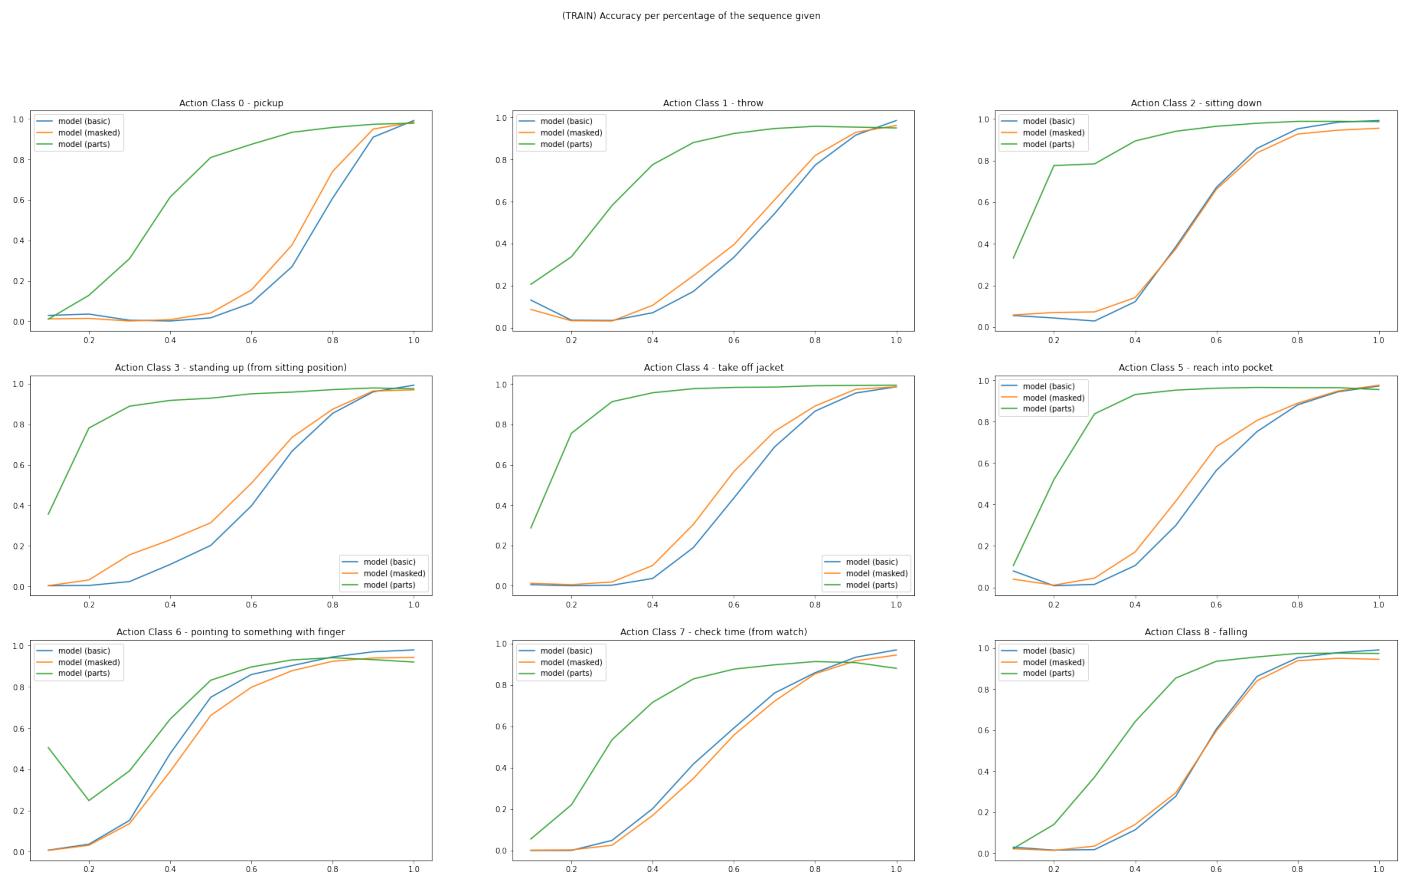

In [47]:
if False:
    
    plt.clf()

    fig, ax = plt.subplots(nrows=3, ncols=3)
    fig.set_figheight(18)
    fig.set_figwidth(32)

    x = np.linspace(start=0.1, stop=1, num=10)

    for i in range(len(classes)):

        ax[i//3][i%3].set_title("Action Class {} - {}".format(i, actions[classes[i]]))
        accuracies = train_results_per_sequence_percentage[i]
        ax[i//3][i%3].plot(x, accuracies[0], label="model (basic)")
        ax[i//3][i%3].plot(x, accuracies[1], label="model (masked)")
        ax[i//3][i%3].plot(x, accuracies[2], label="model (parts)")
        ax[i//3][i%3].legend()

    fig.suptitle("(TRAIN) Accuracy per percentage of the sequence given")
    plt.savefig("./assets/accuracy_per_percentage_train.png")
    plt.show()

else:

    img = plt.imread("./assets/accuracy_per_percentage_train.png")
    plt.figure(figsize=(25,32))
    plt.imshow(img)
    plt.axis("off")

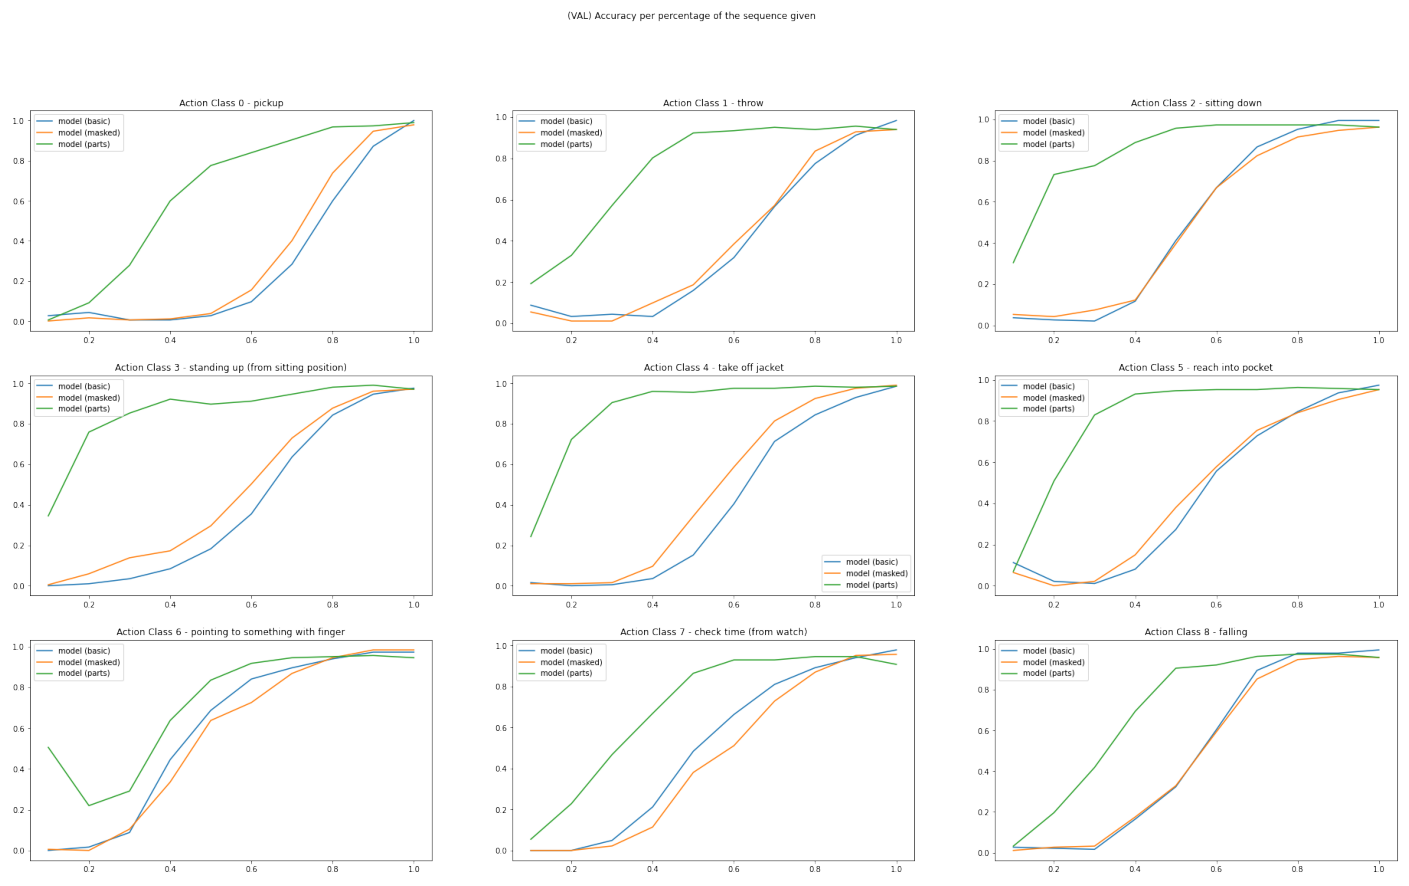

In [48]:
if False:
    
    plt.clf()

    fig, ax = plt.subplots(nrows=3, ncols=3)
    fig.set_figheight(18)
    fig.set_figwidth(32)

    x = np.linspace(start=0.1, stop=1, num=10)

    for i in range(len(classes)):

        ax[i//3][i%3].set_title("Action Class {} - {}".format(i, actions[classes[i]]))
        accuracies = val_results_per_sequence_percentage[i]
        ax[i//3][i%3].plot(x, accuracies[0], label="model (basic)")
        ax[i//3][i%3].plot(x, accuracies[1], label="model (masked)")
        ax[i//3][i%3].plot(x, accuracies[2], label="model (parts)")
        ax[i//3][i%3].legend()

    fig.suptitle("(VAL) Accuracy per percentage of the sequence given")
    plt.savefig("./assets/accuracy_per_percentage_val.png")
    plt.show()

else:

    img = plt.imread("./assets/accuracy_per_percentage_val.png")
    plt.figure(figsize=(25,32))
    plt.imshow(img)
    plt.axis("off")

* As expected the part model performs way better on part of the sequence (able to reach ~75% of accuray with only 40% of the sequences)
* I think it would perform even better if we only train it on sequences with a minimum number of frames superior to 40 frames (which correspnds to 40% of the mean number of frames of the samples)

#### *2.3.D. Accuracy for 2 successive actions*

In [306]:
def accuracy_successive(model, dataset, max_n=None):
    
    accuracies = np.zeros((len(classes),len(classes)))
    nb_frame_needed = np.zeros((len(classes),len(classes)))
    n = max_n
    if max_n is None:
        n = len(dataset)
    sm = nn.Softmax(dim=1).to(device)

    N = np.zeros((len(classes),len(classes)))

    for i in tqdm(range(n)):

        tensor_i,label_i = dataset[i]
        tensor_i = tensor_i.to(device)

        for j in range(n):

            tensor_j,label_j = dataset[j]
            tensor_j = tensor_j.to(device)

            N[label_i][label_j] += 1

            tensor = torch.concat((tensor_i,tensor_j))
            tensor = tensor.reshape(1,tensor.shape[0],75)

            success = int(sm(model(tensor)[0]).argmax().item()==label_j)

            if success:

                accuracies[label_i][label_j] += 1

                nb_frames_i = tensor_i.shape[0]
                nb_frames = tensor.shape[1]
                
                k = 0
                while sm(model(tensor[:,:nb_frames_i+k,:])[0]).argmax().item() != label_j and (nb_frames_i+k+1 < nb_frames):
                    k += 1

                nb_frame_needed[label_i][label_j] += k

    return accuracies/N, nb_frame_needed/N

In [50]:
if False:
    train_result_successive = [accuracy_successive(model, train_dataset3D, int(0.025*len(train_dataset3D))) for model in [model_LSTM03D, model_LSTM03D_masked, model_LSTM03D_part]]
    val_result_successive = [accuracy_successive(model, val_dataset3D, int(0.1*len(val_dataset3D))) for model in [model_LSTM03D, model_LSTM03D_masked, model_LSTM03D_part]]

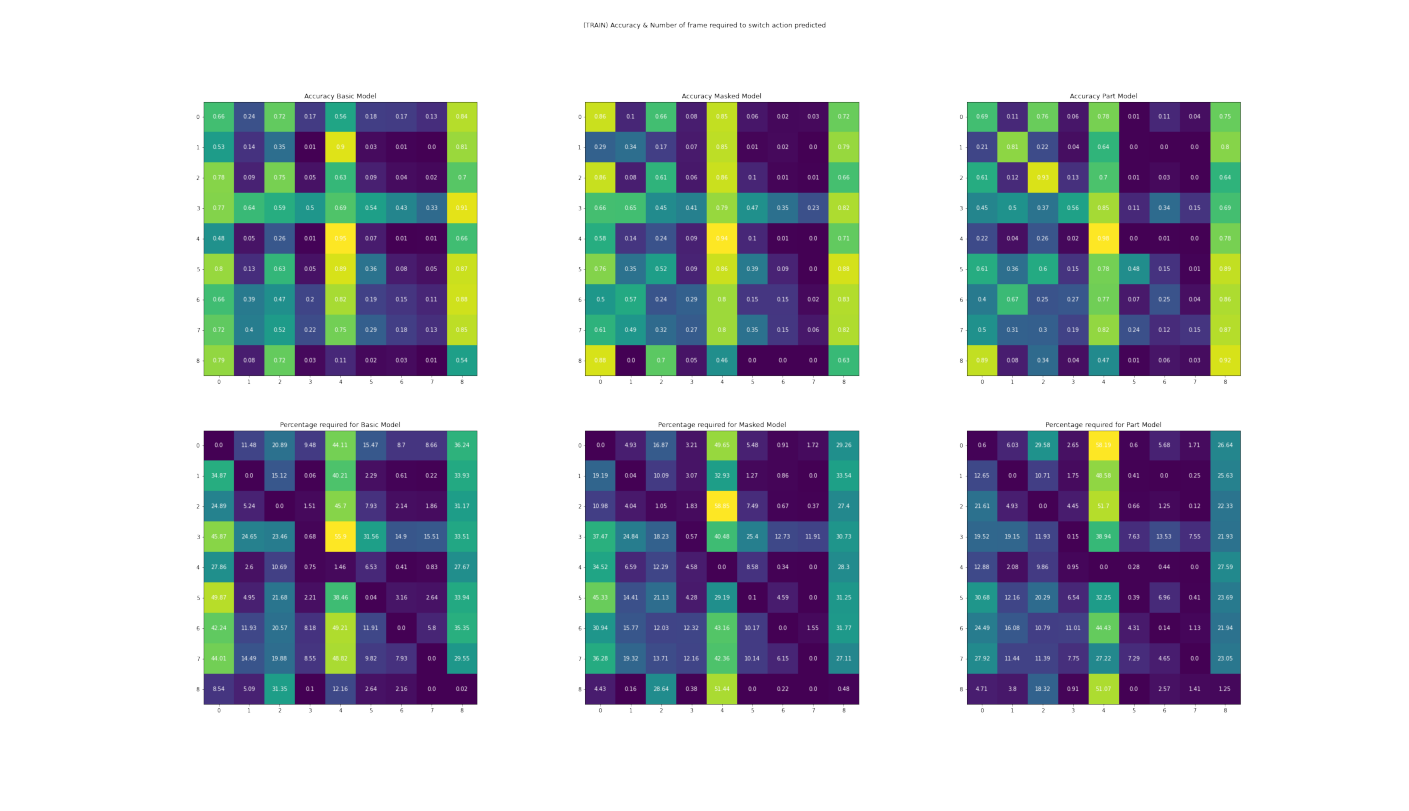

In [51]:
if False:
    
    plt.clf()

    fig, ax = plt.subplots(nrows=2, ncols=3)
    fig.set_figheight(20)
    fig.set_figwidth(35)

    x = np.linspace(start=0.1, stop=1, num=10)
    model_names = ["Basic", "Masked", "Part"]

    for i in range(3):

        ax[0][i].set_title("Accuracy {} Model".format(model_names[i]))
        ax[0][i].imshow(train_result_successive[i][0])
        for j in range(len(classes)):
            for k in range(len(classes)):
                ax[0][i].text(j, k, round(train_result_successive[i][0][k][j],2) , ha="center", va="center", color="w")
        
        ax[1][i].set_title("Percentage required for {} Model".format(model_names[i]))
        ax[1][i].imshow(train_result_successive[i][1])
        for j in range(len(classes)):
            for k in range(len(classes)):
                ax[1][i].text(j, k, round(train_result_successive[i][1][k][j],2) , ha="center", va="center", color="w")

    fig.suptitle("(TRAIN) Accuracy & Number of frame required to switch action predicted")
    plt.savefig("./assets/accuracy_succesive_train.png")
    plt.show()

else:

    img = plt.imread("./assets/accuracy_succesive_train.png")
    plt.figure(figsize=(25,32))
    plt.imshow(img)
    plt.axis("off")

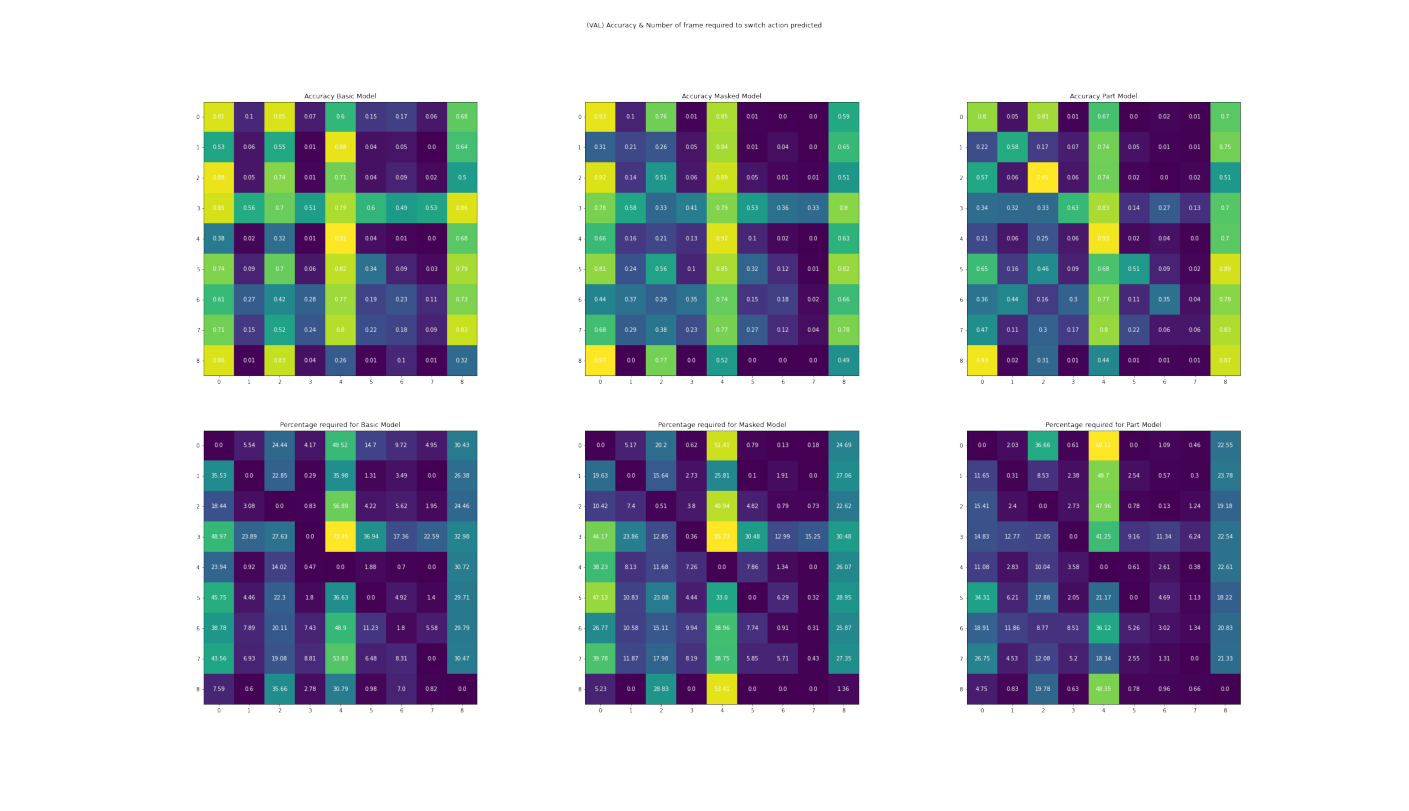

In [52]:
if False:
    
    plt.clf()

    fig, ax = plt.subplots(nrows=2, ncols=3)
    fig.set_figheight(20)
    fig.set_figwidth(35)

    x = np.linspace(start=0.1, stop=1, num=10)
    model_names = ["Basic", "Masked", "Part"]

    for i in range(3):

        ax[0][i].set_title("Accuracy {} Model".format(model_names[i]))
        ax[0][i].imshow(val_result_successive[i][0])
        for j in range(len(classes)):
            for k in range(len(classes)):
                ax[0][i].text(j, k, round(val_result_successive[i][0][k][j],2) , ha="center", va="center", color="w")
        
        ax[1][i].set_title("Percentage required for {} Model".format(model_names[i]))
        ax[1][i].imshow(val_result_successive[i][1])
        for j in range(len(classes)):
            for k in range(len(classes)):
                ax[1][i].text(j, k, round(val_result_successive[i][1][k][j],2) , ha="center", va="center", color="w")

    fig.suptitle("(VAL) Accuracy & Number of frame required to switch action predicted")
    plt.savefig("./assets/accuracy_succesive_val.png")
    plt.show()

else:

    img = plt.imread("./assets/accuracy_succesive_val.png")
    plt.figure(figsize=(25,32))
    plt.imshow(img)
    plt.axis("off")

* Not that great.. not even able to predict two consecutive actions...
* No need to go further and investigate more successive actions
* why not use the previosu results (part model) and use a sliding window for long inputs ? Since we found that 40% was fine, let's consider 50% of the mean number of frames for more robustness

#### *2.3.E. Accuracy for 2 successive actions with time window = 50 Frames*

In [163]:
def accuracy_successive_bis(model, dataset, max_n=-1, window_size=50):
    
    accuracies = np.zeros((len(classes),len(classes)))
    nb_frame_needed = np.zeros((len(classes),len(classes)))
    n = max_n
    if max_n < 0:
        n = len(dataset)
    sm = nn.Softmax(dim=1).to(device)

    N = np.zeros((len(classes),len(classes)))

    for i in tqdm(range(n)):

        tensor_i,label_i = dataset[i]
        tensor_i = tensor_i.to(device)

        for j in range(n):

            tensor_j,label_j = dataset[j]
            tensor_j = tensor_j.to(device)

            N[label_i][label_j] += 1

            tensor = torch.concat((tensor_i,tensor_j))
            tensor = tensor.reshape(1,tensor.shape[0],75)

            success = int(sm(model(tensor[:,window_size:,:])[0]).argmax().item()==label_j)

            if success:

                accuracies[label_i][label_j] += 1

                nb_frames_i = tensor_i.shape[0]
                nb_frames_j = tensor_j.shape[0]
                nb_frames = nb_frames_i+nb_frames_j
                
                k = 0
                while sm(model(tensor[:,max(0,nb_frames_i+k-window_size):nb_frames_i+k,:])[0]).argmax().item() != label_j and (nb_frames_i+k+1 < nb_frames):
                    k += 1

                nb_frame_needed[label_i][label_j] += k

    return accuracies/N, nb_frame_needed/N

In [164]:
if False:
    train_result_successive_bis = [accuracy_successive_bis(model, train_dataset3D, int(0.025*len(train_dataset3D))) for model in [model_LSTM03D, model_LSTM03D_masked, model_LSTM03D_part]]
    val_result_successive_bis = [accuracy_successive_bis(model, val_dataset3D, int(0.1*len(val_dataset3D))) for model in [model_LSTM03D, model_LSTM03D_masked, model_LSTM03D_part]]

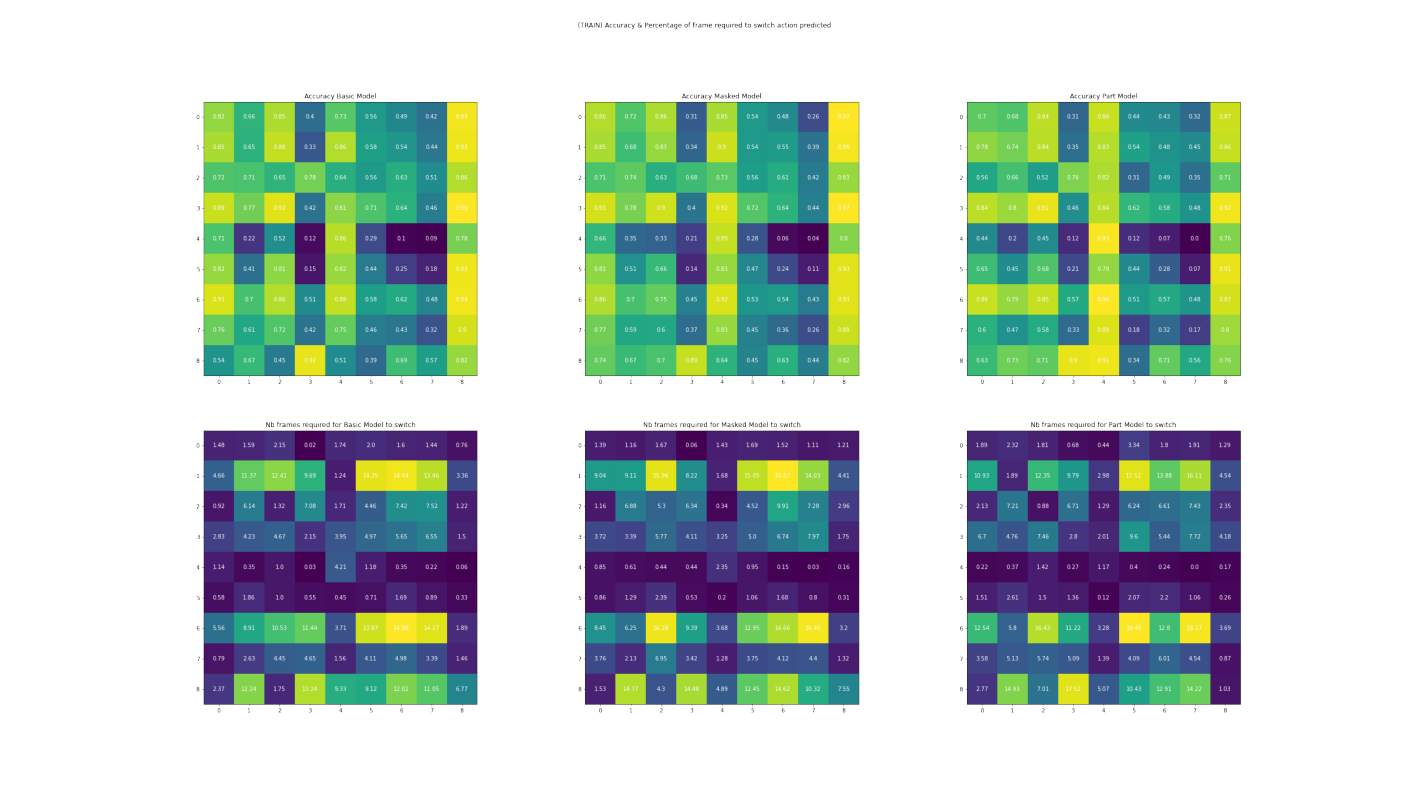

In [55]:
if False:
    
    plt.clf()

    fig, ax = plt.subplots(nrows=2, ncols=3)
    fig.set_figheight(20)
    fig.set_figwidth(35)

    x = np.linspace(start=0.1, stop=1, num=10)
    model_names = ["Basic", "Masked", "Part"]

    for i in range(3):

        ax[0][i].set_title("Accuracy {} Model".format(model_names[i]))
        ax[0][i].imshow(train_result_successive_bis[i][0])
        for j in range(len(classes)):
            for k in range(len(classes)):
                ax[0][i].text(j, k, round(train_result_successive_bis[i][0][k][j],2) , ha="center", va="center", color="w")
        
        ax[1][i].set_title("Nb frames required for {} Model to switch".format(model_names[i]))
        ax[1][i].imshow(train_result_successive_bis[i][1])
        for j in range(len(classes)):
            for k in range(len(classes)):
                ax[1][i].text(j, k, round(train_result_successive_bis[i][1][k][j],2) , ha="center", va="center", color="w")

    fig.suptitle("(TRAIN) Accuracy & Percentage of frame required to switch action predicted")
    plt.savefig("./assets/accuracy_succesive_bis_train.png")
    plt.show()

else:

    img = plt.imread("./assets/accuracy_succesive_bis_train.png")
    plt.figure(figsize=(25,32))
    plt.imshow(img)
    plt.axis("off")

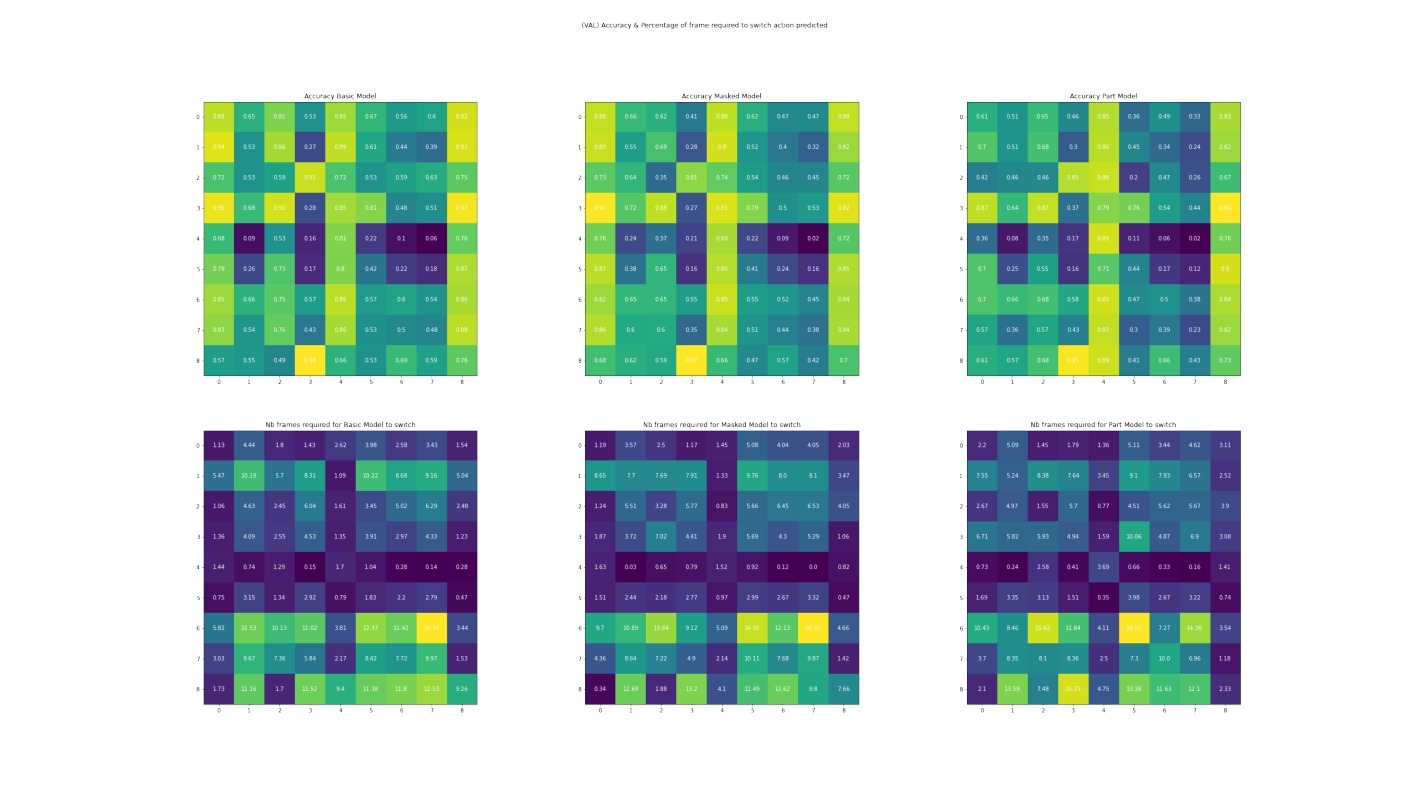

In [56]:
if False:
    
    plt.clf()

    fig, ax = plt.subplots(nrows=2, ncols=3)
    fig.set_figheight(20)
    fig.set_figwidth(35)

    x = np.linspace(start=0.1, stop=1, num=10)
    model_names = ["Basic", "Masked", "Part"]

    for i in range(3):

        ax[0][i].set_title("Accuracy {} Model".format(model_names[i]))
        ax[0][i].imshow(val_result_successive_bis[i][0])
        for j in range(len(classes)):
            for k in range(len(classes)):
                ax[0][i].text(j, k, round(val_result_successive_bis[i][0][k][j],2) , ha="center", va="center", color="w")
        
        ax[1][i].set_title("Nb frames required for {} Model to switch".format(model_names[i]))
        ax[1][i].imshow(val_result_successive_bis[i][1])
        for j in range(len(classes)):
            for k in range(len(classes)):
                ax[1][i].text(j, k, round(val_result_successive_bis[i][1][k][j],2) , ha="center", va="center", color="w")

    fig.suptitle("(VAL) Accuracy & Percentage of frame required to switch action predicted")
    plt.savefig("./assets/accuracy_succesive_bis_val.png")
    plt.show()

else:

    img = plt.imread("./assets/accuracy_succesive_bis_val.png")
    plt.figure(figsize=(25,32))
    plt.imshow(img)
    plt.axis("off")

#### *2.3.F. Accuracy for 2 successive actions with time window = 75 Frames*

In [73]:
train_result_successive_bis_3 = [accuracy_successive_bis(model, train_dataset3D, max_n=int(0.0125*len(train_dataset3D)), window_size=75) for model in [model_LSTM03D, model_LSTM03D_masked, model_LSTM03D_part]]
val_result_successive_bis_3 = [accuracy_successive_bis(model, val_dataset3D,max_n=int(0.05*len(val_dataset3D)), window_size=75) for model in [model_LSTM03D, model_LSTM03D_masked, model_LSTM03D_part]]

100%|██████████| 84/84 [11:25<00:00,  8.16s/it]


<Figure size 432x288 with 0 Axes>

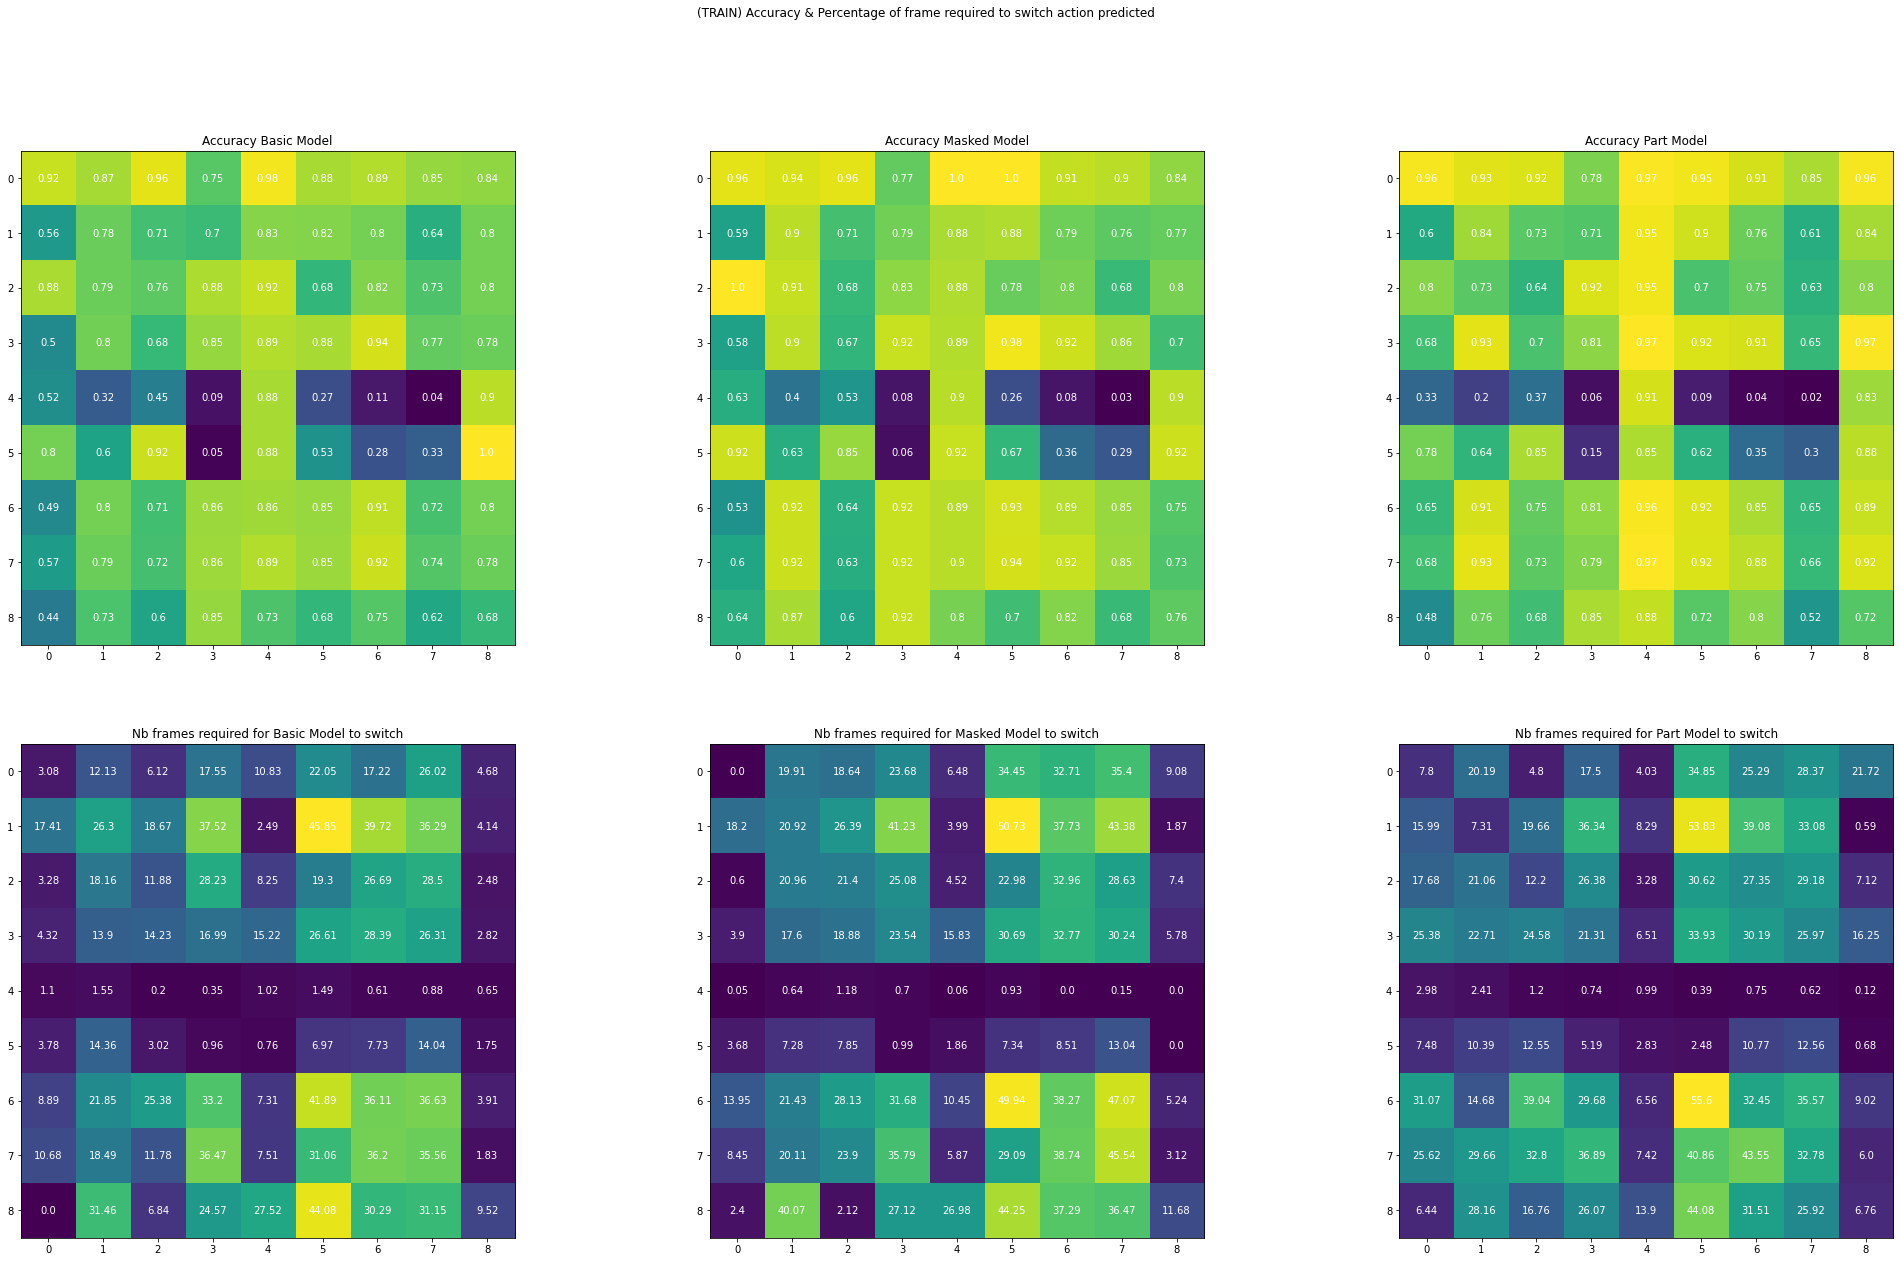

In [77]:
if True:
    
    plt.clf()

    fig, ax = plt.subplots(nrows=2, ncols=3)
    fig.set_figheight(20)
    fig.set_figwidth(35)

    x = np.linspace(start=0.1, stop=1, num=10)
    model_names = ["Basic", "Masked", "Part"]

    for i in range(3):

        ax[0][i].set_title("Accuracy {} Model".format(model_names[i]))
        ax[0][i].imshow(train_result_successive_bis_3[i][0])
        for j in range(len(classes)):
            for k in range(len(classes)):
                ax[0][i].text(j, k, round(train_result_successive_bis_3[i][0][k][j],2) , ha="center", va="center", color="w")
        
        ax[1][i].set_title("Nb frames required for {} Model to switch".format(model_names[i]))
        ax[1][i].imshow(train_result_successive_bis_3[i][1])
        for j in range(len(classes)):
            for k in range(len(classes)):
                ax[1][i].text(j, k, round(train_result_successive_bis_3[i][1][k][j],2) , ha="center", va="center", color="w")

    fig.suptitle("(TRAIN) Accuracy & Percentage of frame required to switch action predicted")
    plt.savefig("./assets/accuracy_succesive_bis_train_3.png")
    plt.show()

else:

    img = plt.imread("./assets/accuracy_succesive_bis_train_3.png")
    plt.figure(figsize=(25,32))
    plt.imshow(img)
    plt.axis("off")

<Figure size 432x288 with 0 Axes>

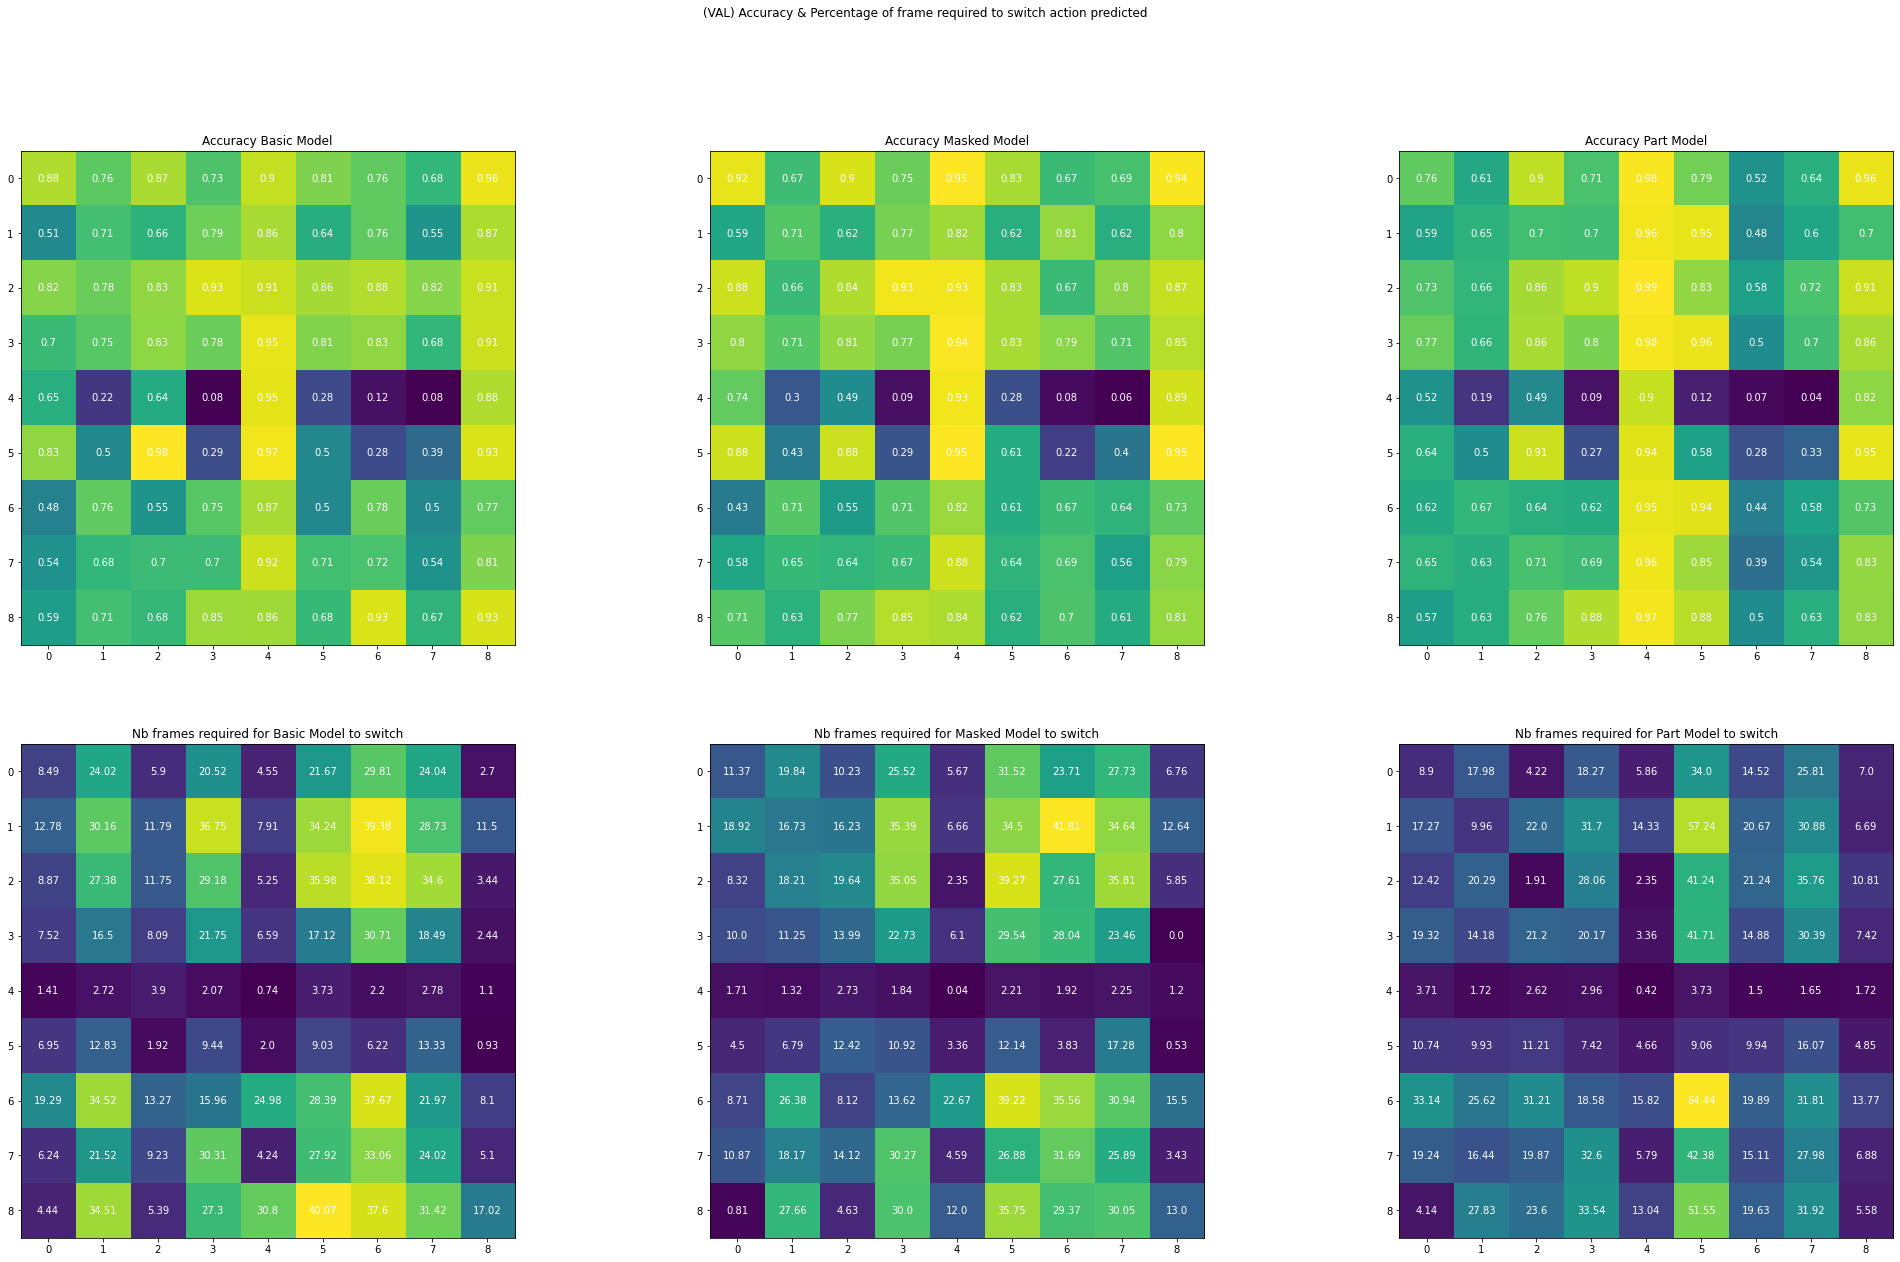

In [75]:
if True:
    
    plt.clf()

    fig, ax = plt.subplots(nrows=2, ncols=3)
    fig.set_figheight(20)
    fig.set_figwidth(35)

    x = np.linspace(start=0.1, stop=1, num=10)
    model_names = ["Basic", "Masked", "Part"]

    for i in range(3):

        ax[0][i].set_title("Accuracy {} Model".format(model_names[i]))
        ax[0][i].imshow(val_result_successive_bis_3[i][0])
        for j in range(len(classes)):
            for k in range(len(classes)):
                ax[0][i].text(j, k, round(val_result_successive_bis_3[i][0][k][j],2) , ha="center", va="center", color="w")
        
        ax[1][i].set_title("Nb frames required for {} Model to switch".format(model_names[i]))
        ax[1][i].imshow(val_result_successive_bis_3[i][1])
        for j in range(len(classes)):
            for k in range(len(classes)):
                ax[1][i].text(j, k, round(val_result_successive_bis_3[i][1][k][j],2) , ha="center", va="center", color="w")

    fig.suptitle("(VAL) Accuracy & Percentage of frame required to switch action predicted")
    plt.savefig("./assets/accuracy_succesive_bis_val_3.png")
    plt.show()

else:

    img = plt.imread("./assets/accuracy_succesive_bis_val_3.png")
    plt.figure(figsize=(25,32))
    plt.imshow(img)
    plt.axis("off")

* Now that we have a fixed time window it works way better !
* Let's dig into this long memory issue ("not able to forget the past") and consider a model who doesn't clean its memory every iteration when training.

### *2.4. Critic of the results*

From the study of the dataset we understand the importance of data that is not necessarily complete (either temporally by considering one of the frames or spatially by hiding part of the joints). However, it seems that because of the way the model is trained, it is not able to give more importance to its long-term memory. This is one of the reasons why it performs better when forced into a window. Thus it seems relevant to confront it, in a training situation, with non-monotonous sequences of actions (several types of actions) or not to reset its memory with each new input.

Thus we will now set our dataset as follows when training our model:

* we will randomly mask joints of some skeletons (up to possibly 10% according to the results obtained in part *2.3.B*)

* we will consider random parts of the sequences (between 40% and 100% taking into account the results obtained in section *2.3.C*) while keeping a minimum number of frames at 25

* when the total number of frames is below 40 we will concatenante to our input data part of an other sequence with a different label

* we will study the effect of not reinitializing the memory of our lstm model.

___

## **3. BUILDING THE MODEL (3D DATA) :** MEMORY INFLUENCE

### *3.1. Dataset*

In [270]:
class HumanActionDataset3DF(Dataset):

    def __init__(self, data_dir, data_files, classes, with_depth=True, max_masked_percentage=0.1, min_nb_frames=25, training=False):
        self.data_dir = data_dir
        self.data_files = [data_file for data_file in data_files if int(data_file[17:-4])-1 in classes]
        self.classes = classes
        self.max_masked_percentage = max(0,min(max_masked_percentage,0.1))
        self.min_nb_frames = min_nb_frames
        self.with_depth = with_depth
        self.training = training

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        tensor = torch.Tensor(np.load(self.data_dir + self.data_files[idx]))
        if self.training:
            if tensor.shape[0] > self.min_nb_frames:
                max_length = np.random.randint(low=self.min_nb_frames, high=tensor.shape[0]+1)
                end = np.random.randint(low=max_length, high=tensor.shape[0]+1)
                tensor = tensor[end-max_length:end,:,:]
            if tensor.shape[0] < 40:
                idx_prev = np.random.randint(low=0, high=len(self.data_files))
                tensor_prev = torch.Tensor(np.load(self.data_dir + self.data_files[idx_prev]))
                tensor_prev = tensor_prev[-40+tensor.shape[0]:,:,:]
                tensor = torch.concat((tensor_prev,tensor))
            if np.random.random() < 0.25:
                nb_to_hide = np.random.randint(low=1, high=int(self.max_masked_percentage*25)+1)
                parts_to_hide = np.random.choice(a=25, size=nb_to_hide, replace=False)
                for part_to_hide in parts_to_hide:
                    tensor[:,part_to_hide,:] = -100
        if self.with_depth:
            tensor = tensor.reshape((tensor.shape[0], 75))
        else:
            tensor = torch.tensor([[tensor[i,k//2,k%2] for k in range(50)] for i in range(tensor.shape[0])])
        label = self.classes.index(int(self.data_files[idx][17:-4])-1)
        return (tensor, label)

In [271]:
HAD3DF = HumanActionDataset3DF(data3D_dir, data3D_files, classes, with_depth=True, max_masked_percentage=0.1, min_nb_frames=25, training=False)
HAD3DF_train = HumanActionDataset3DF(data3D_dir, data3D_files, classes, with_depth=True, max_masked_percentage=0.1, min_nb_frames=25, training=True)

In [273]:
train_dataset3DF, val_dataset3DF = torch.utils.data.random_split(HAD3DF, [int(0.80*len(HAD3DF)), len(HAD3DF)-int(0.80*len(HAD3DF))])
train_dataset3DF_train, val_dataset3DF_train = torch.utils.data.random_split(HAD3DF, [int(0.80*len(HAD3DF_train)), len(HAD3DF_train)-int(0.80*len(HAD3DF_train))])

train_dataloader3DF = torch.utils.data.DataLoader(dataset=train_dataset3DF, batch_size=32, collate_fn=PadSequence(), shuffle=True)
train_dataloader3DF_train = torch.utils.data.DataLoader(dataset=train_dataset3DF_train, batch_size=32, collate_fn=PadSequence(), shuffle=True)
val_dataloader3DF = torch.utils.data.DataLoader(dataset=val_dataset3DF, batch_size=32, collate_fn=PadSequence(), shuffle=True)
val_dataloader3DF_train = torch.utils.data.DataLoader(dataset=val_dataset3DF_train, batch_size=32, collate_fn=PadSequence(), shuffle=True)

### *3.2. Definition*

In [274]:
model_LSTM3DF = LSTM03D(nb_classes=len(classes), input_size=75, hidden_size_lstm=256, hidden_size_classifier=128, num_layers=1, device=device)
model_LSTM3DF.to(device)
model_LSTM3DF.eval()

LSTM03D(
  (lstm): LSTM(75, 256, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=9, bias=True)
  )
)

### *3.3. Training*

In [275]:
def train_modelF(model, criterion, optimizer, nb_epochs, epoch_print_frequence, train_dataloader, val_dataloader, train_dataset, val_dataset):

    s = time.time()

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    h_n, c_n = None, None

    for epoch in range(nb_epochs):
        
        running_loss_train, running_loss_val, running_acc_train, running_acc_val = 0, 0, 0, 0

        for train in [True, False]:

            if train:
                dataloader = train_dataloader
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()

            for data in dataloader:
                
                inputs = data[0].to(device)
                labels_raw = data[-1]
                labels = torch.zeros((inputs.shape[0], len(classes)))
                for i in range(len(labels_raw)):
                    labels[i][int(labels_raw[i])] = 1
                labels = labels.to(device)

                if train:
                    optimizer.zero_grad()

                
                if inputs.shape[0] < 32 and h_n != None:
                    h_n = h_n[:,:inputs.size(0),:]
                    c_n = c_n[:,:inputs.size(0),:]
                elif h_n != None:
                    if h_n.shape[1] < 32:
                        h_n, c_n = None, None
                outputs_for_loss, h_n, c_n = model(inputs, h_n, c_n)
                h_n, c_n = copy.copy(h_n), copy.copy(c_n)
                h_n = h_n.to(device)
                c_n = c_n.to(device)
                sm = nn.Softmax(dim=1).to(device)
                outputs = sm(outputs_for_loss)
                outputs = outputs.to(device)
                loss = criterion(outputs_for_loss, labels)

                if train:
                    loss.backward()
                    optimizer.step()
                    running_loss_train += loss.item()
                    running_acc_train += int(torch.sum(outputs.argmax(dim=1) == labels.argmax(dim=1)))
                else:
                    running_loss_val += loss.item()
                    running_acc_val += int(torch.sum(outputs.argmax(dim=1) == labels.argmax(dim=1)))

        running_loss_train /= len(train_dataloader)
        running_loss_val /= len(val_dataloader)
        running_acc_train /= len(train_dataset)
        running_acc_val /= len(val_dataset)

        train_losses.append(running_loss_train)
        val_losses.append(running_loss_val)
        train_accs.append(running_acc_train)
        val_accs.append(running_acc_val)

        if (epoch+1) % epoch_print_frequence == 0:
            print("epochs {} ({} s) | train loss : {} | val loss : {} | train acc : {} | val acc : {}".format(
                epoch+1,
                int(time.time()-s),
                running_loss_train,
                running_loss_val,
                running_acc_train,
                running_acc_val
            ))
    
    return train_losses, val_losses, train_accs, val_accs

In [276]:
criterion_LSTM3DF = nn.CrossEntropyLoss()
optimizer_LSTM3DF = torch.optim.Adam(params=model_LSTM3DF.parameters(), lr=1e-4)
lr_scheduler_LSTM3DF = torch.optim.lr_scheduler.StepLR(optimizer_LSTM3DF, step_size=10, gamma=0.1)

In [279]:
nb_epochs = 200
epoch_print_frequence = 10

In [289]:
if False:

    losses_accs_LSTM3DF = train_modelF(model_LSTM3DF, criterion_LSTM3DF, optimizer_LSTM3DF, nb_epochs, epoch_print_frequence, train_dataloader3DF_train, val_dataloader3DF_train, train_dataset3DF_train, val_dataset3DF_train)
    torch.save(model_LSTM3DF.state_dict(), "./models_saved/LSTM3DF.pt")

else:

    print("\
epochs  10  (141 s) | train loss : 0.5201 | val loss : 0.5297 | train acc : 0.8160 | val acc : 0.8164\n\
epochs  20  (311 s) | train loss : 0.3652 | val loss : 0.4338 | train acc : 0.8741 | val acc : 0.8481\n\
epochs  30  (471 s) | train loss : 0.2901 | val loss : 0.3728 | train acc : 0.8990 | val acc : 0.8858\n\
epochs  40  (628 s) | train loss : 0.2344 | val loss : 0.2851 | train acc : 0.9195 | val acc : 0.9070\n\
epochs  50  (803 s) | train loss : 0.1895 | val loss : 0.3014 | train acc : 0.9329 | val acc : 0.8988\n\
epochs  60  (969 s) | train loss : 0.1662 | val loss : 0.3376 | train acc : 0.9429 | val acc : 0.9164\n\
epochs  70 (1139 s) | train loss : 0.1115 | val loss : 0.3109 | train acc : 0.9611 | val acc : 0.9164\n\
epochs  80 (1303 s) | train loss : 0.1040 | val loss : 0.2515 | train acc : 0.9640 | val acc : 0.9276\n\
epochs  90 (1499 s) | train loss : 0.1054 | val loss : 0.2784 | train acc : 0.9613 | val acc : 0.9241\n\
epochs 100 (1689 s) | train loss : 0.0806 | val loss : 0.2494 | train acc : 0.9731 | val acc : 0.9323\n\
epochs 110 (1870 s) | train loss : 0.0658 | val loss : 0.2889 | train acc : 0.9787 | val acc : 0.9158\n\
epochs 120 (2049 s) | train loss : 0.0683 | val loss : 0.2945 | train acc : 0.9747 | val acc : 0.9247\n\
epochs 130 (2219 s) | train loss : 0.0530 | val loss : 0.2972 | train acc : 0.9879 | val acc : 0.9158\n\
epochs 140 (2379 s) | train loss : 0.0687 | val loss : 0.2738 | train acc : 0.9763 | val acc : 0.9258\n\
epochs 150 (2538 s) | train loss : 0.0614 | val loss : 0.3775 | train acc : 0.9792 | val acc : 0.9282\n\
epochs 160 (2697 s) | train loss : 0.0206 | val loss : 0.2664 | train acc : 0.9941 | val acc : 0.9347\n\
epochs 170 (2891 s) | train loss : 0.0258 | val loss : 0.2716 | train acc : 0.9920 | val acc : 0.9370\n\
epochs 180 (3074 s) | train loss : 0.0240 | val loss : 0.2752 | train acc : 0.9925 | val acc : 0.9400\n\
epochs 190 (3305 s) | train loss : 0.0242 | val loss : 0.2600 | train acc : 0.9925 | val acc : 0.9347\n\
epochs 200 (3508 s) | train loss : 0.0569 | val loss : 0.2900 | train acc : 0.9804 | val acc : 0.9258")

epochs  10  (141 s) | train loss : 0.5201 | val loss : 0.5297 | train acc : 0.8160 | val acc : 0.8164
epochs  20  (311 s) | train loss : 0.3652 | val loss : 0.4338 | train acc : 0.8741 | val acc : 0.8481
epochs  30  (471 s) | train loss : 0.2901 | val loss : 0.3728 | train acc : 0.8990 | val acc : 0.8858
epochs  40  (628 s) | train loss : 0.2344 | val loss : 0.2851 | train acc : 0.9195 | val acc : 0.9070
epochs  50  (803 s) | train loss : 0.1895 | val loss : 0.3014 | train acc : 0.9329 | val acc : 0.8988
epochs  60  (969 s) | train loss : 0.1662 | val loss : 0.3376 | train acc : 0.9429 | val acc : 0.9164
epochs  70 (1139 s) | train loss : 0.1115 | val loss : 0.3109 | train acc : 0.9611 | val acc : 0.9164
epochs  80 (1303 s) | train loss : 0.1040 | val loss : 0.2515 | train acc : 0.9640 | val acc : 0.9276
epochs  90 (1499 s) | train loss : 0.1054 | val loss : 0.2784 | train acc : 0.9613 | val acc : 0.9241
epochs 100 (1689 s) | train loss : 0.0806 | val loss : 0.2494 | train acc : 0.9731

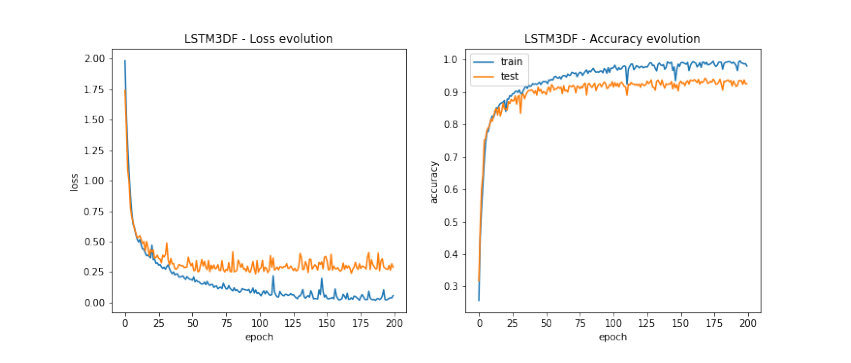

In [290]:
if False:
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

    ax[0].set(title="LSTM3DF - Loss evolution")
    ax[0].plot(losses_accs_LSTM3DF[0], label="train")
    ax[0].plot(losses_accs_LSTM3DF[1], label="test")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")

    ax[1].set(title="LSTM3DF - Accuracy evolution")
    ax[1].plot(losses_accs_LSTM3DF[2], label="train")
    ax[1].plot(losses_accs_LSTM3DF[3], label="test")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("accuracy")

    plt.legend()
    plt.savefig("./models_saved/LSTM3DF.png")
    plt.show()

else:

    img = plt.imread("./models_saved/LSTM3DF.png")
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    plt.axis("off")

In [291]:
model_LSTM3DF = LSTM03D(nb_classes=len(classes), input_size=75, hidden_size_lstm=256, hidden_size_classifier=128, num_layers=1, device=device)
model_LSTM3DF.to(device)
model_LSTM3DF.load_state_dict(torch.load("./models_saved/LSTM3DF.pt"))
model_LSTM3DF.eval()

LSTM03D(
  (lstm): LSTM(75, 256, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=9, bias=True)
  )
)

### *3.4. Evaluation*

#### *3.4.A. On full sequences*

In [292]:
train_results_per_modelF = accuracy_on_full_sequence([model_LSTM3DF], train_dataset3D)
val_results_per_modelF = accuracy_on_full_sequence([model_LSTM3DF], val_dataset3D)

train_results_per_modelF_data = {"modelF": train_results_per_modelF[0]}
train_df = pd.DataFrame(train_results_per_modelF_data).transpose()
train_df.columns = ["class {}".format(i) for i in range(train_results_per_modelF.shape[1])]
train_df["average"] = np.average(train_results_per_modelF, axis=1)
print("ON TRAINSET")
display(train_df)

val_data_per_modelF_data = {"modelF": val_results_per_modelF[0]}
val_df = pd.DataFrame(val_data_per_modelF_data).transpose()
val_df.columns = ["class {}".format(i) for i in range(val_results_per_modelF.shape[1])]
val_df["average"] = np.average(val_results_per_modelF, axis=1)
print("ON VALSET")
display(val_df)

100%|██████████| 1699/1699 [00:07<00:00, 220.94it/s]

ON TRAINSET


,class 0,class 1,class 2,class 3,class 4,class 5,class 6,class 7,class 8,average
modelF,0.98672,0.933066,0.979003,0.973154,0.977807,0.938992,0.910506,0.88874,0.98262,0.95229


ON VALSET


,class 0,class 1,class 2,class 3,class 4,class 5,class 6,class 7,class 8,average
modelF,0.989474,0.944162,0.96648,0.973822,0.96648,0.927083,0.901734,0.845,0.984848,0.944343


#### *3.4.B. On masked sequences*

In [298]:
if False:
    
    train_results_per_masked_percentageF = [
        accuracy_per_masked_percentage([model_LSTM3DF], train_dataset3D, action_class=elem, min_percentage=0.85, max_percentage=1.00, steps=4) for elem in range(len(classes))
    ]

    val_results_per_masked_percentageF = [
        accuracy_per_masked_percentage([model_LSTM3DF], val_dataset3D, action_class=elem, min_percentage=0.85, max_percentage=1.00, steps=4) for elem in range(len(classes))
    ]

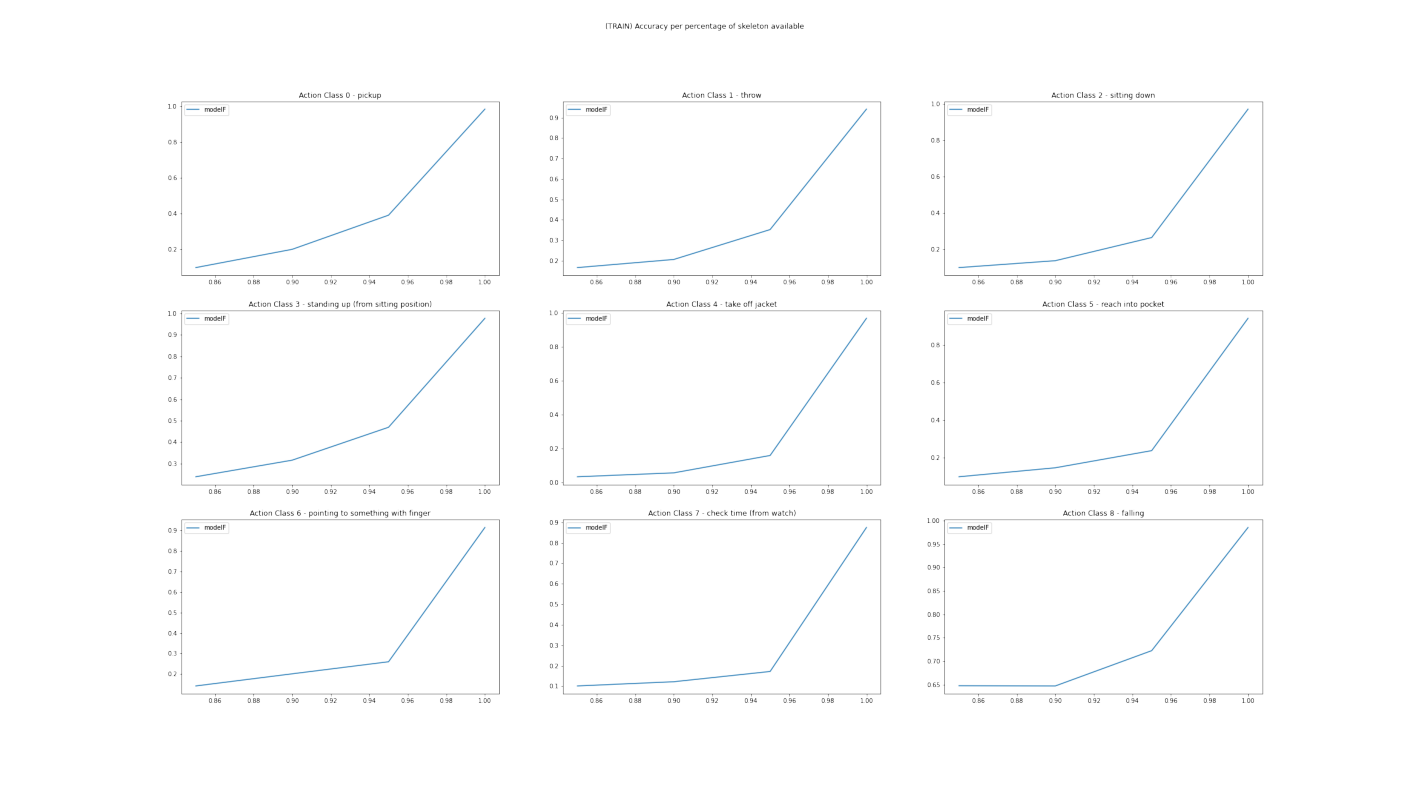

In [296]:
if False:
    
    plt.clf()

    fig, ax = plt.subplots(nrows=3, ncols=3)
    fig.set_figheight(18)
    fig.set_figwidth(32)

    x = np.linspace(start=0.85, stop=1.0, num=4)

    for i in range(len(classes)):

        ax[i//3][i%3].set_title("Action Class {} - {}".format(i, actions[classes[i]]))
        accuracies = train_results_per_masked_percentageF[i]
        ax[i//3][i%3].plot(x, accuracies[0], label="modelF")
        ax[i//3][i%3].legend()

    fig.suptitle("(TRAIN) Accuracy per percentage of skeleton available")
    plt.savefig("./assets/acc_per_skeleton_percentage_trainF.png")
    plt.show()

else:

    img = plt.imread("./assets/acc_per_skeleton_percentage_trainF.png")
    plt.figure(figsize=(25,32))
    plt.imshow(img)
    plt.axis("off")

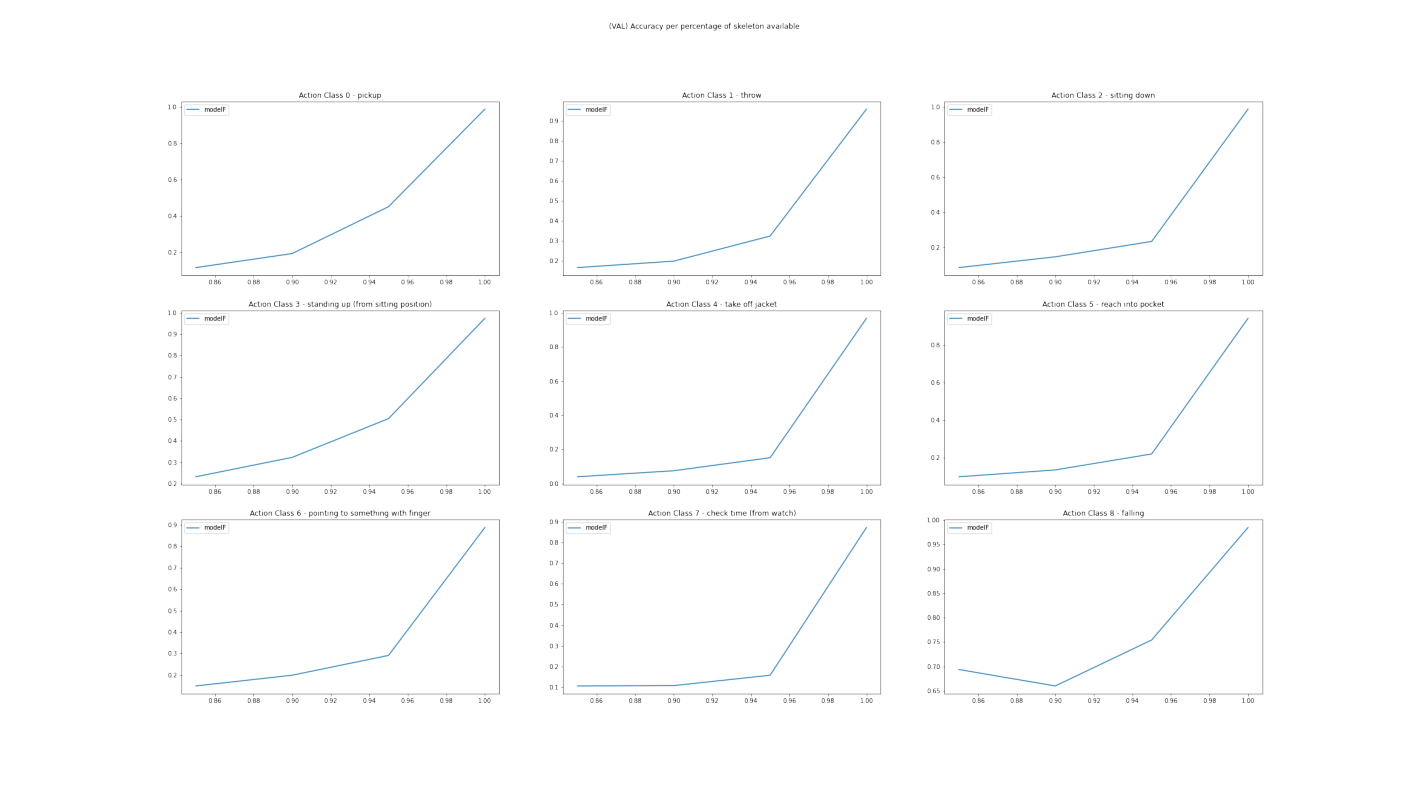

In [297]:
if False:
    
    plt.clf()

    fig, ax = plt.subplots(nrows=3, ncols=3)
    fig.set_figheight(18)
    fig.set_figwidth(32)

    x = np.linspace(start=0.85, stop=1.00, num=4)

    for i in range(len(classes)):

        ax[i//3][i%3].set_title("Action Class {} - {}".format(i, actions[classes[i]]))
        accuracies = val_results_per_masked_percentageF[i]
        ax[i//3][i%3].plot(x, accuracies[0], label="modelF")
        ax[i//3][i%3].legend()

    fig.suptitle("(VAL) Accuracy per percentage of skeleton available")
    plt.savefig("./assets/acc_per_skeleton_percentage_valF.png")
    plt.show()

else:

    img = plt.imread("./assets/acc_per_skeleton_percentage_valF.png")
    plt.figure(figsize=(25,32))
    plt.imshow(img)
    plt.axis("off")

#### *3.4.C. On part of the sequence*

In [302]:
if False:
    
    train_results_per_sequence_percentageF = [
        accuracy_per_sequence_percentage([model_LSTM3DF], train_dataset3D, action_class=elem) for elem in range(len(classes))
    ]

    val_results_per_sequence_percentageF = [
        accuracy_per_sequence_percentage([model_LSTM3DF], val_dataset3D, action_class=elem) for elem in range(len(classes))
    ]

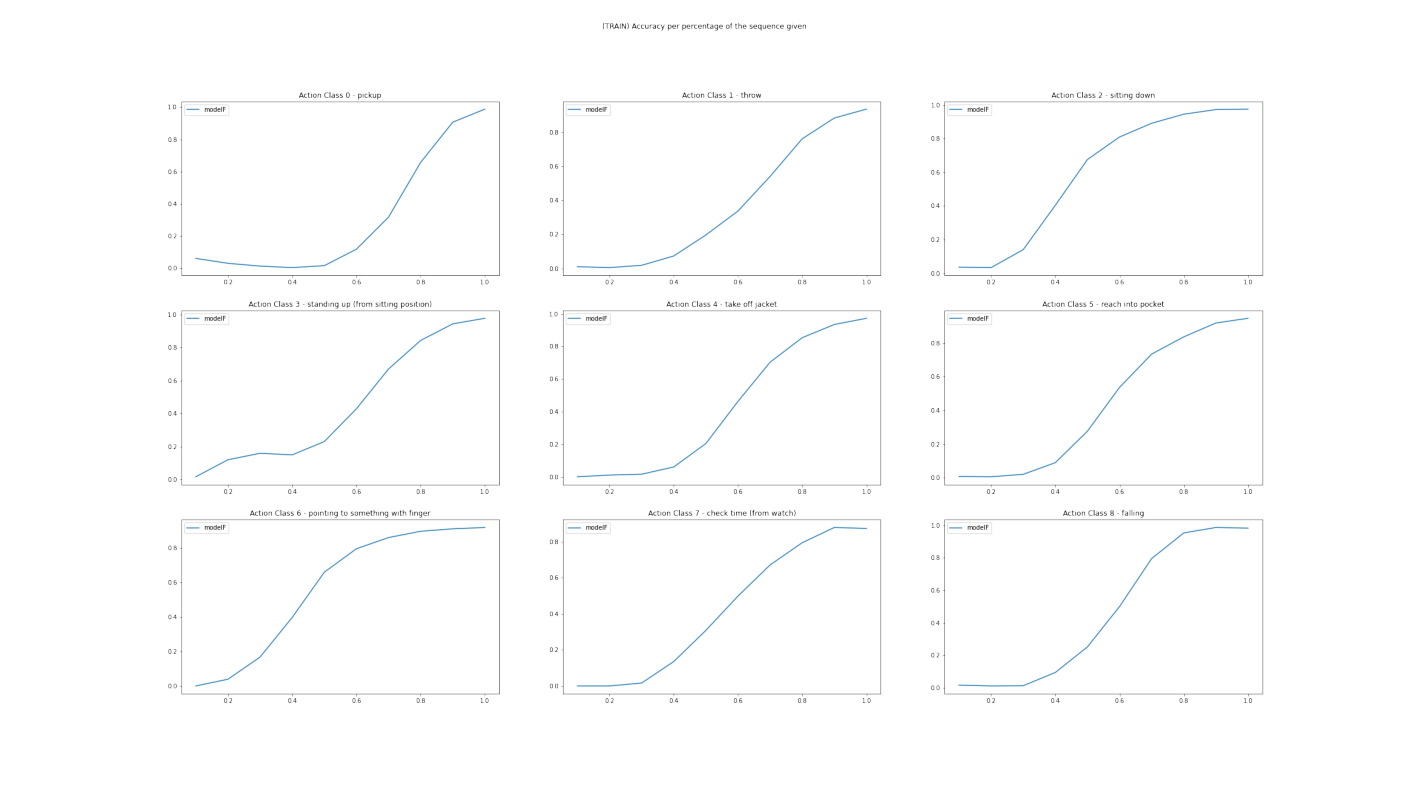

In [303]:
if False:
    
    plt.clf()

    fig, ax = plt.subplots(nrows=3, ncols=3)
    fig.set_figheight(18)
    fig.set_figwidth(32)

    x = np.linspace(start=0.1, stop=1, num=10)

    for i in range(len(classes)):

        ax[i//3][i%3].set_title("Action Class {} - {}".format(i, actions[classes[i]]))
        accuracies = train_results_per_sequence_percentageF[i]
        ax[i//3][i%3].plot(x, accuracies[0], label="modelF")
        ax[i//3][i%3].legend()

    fig.suptitle("(TRAIN) Accuracy per percentage of the sequence given")
    plt.savefig("./assets/accuracy_per_percentage_trainF.png")
    plt.show()

else:

    img = plt.imread("./assets/accuracy_per_percentage_trainF.png")
    plt.figure(figsize=(25,32))
    plt.imshow(img)
    plt.axis("off")

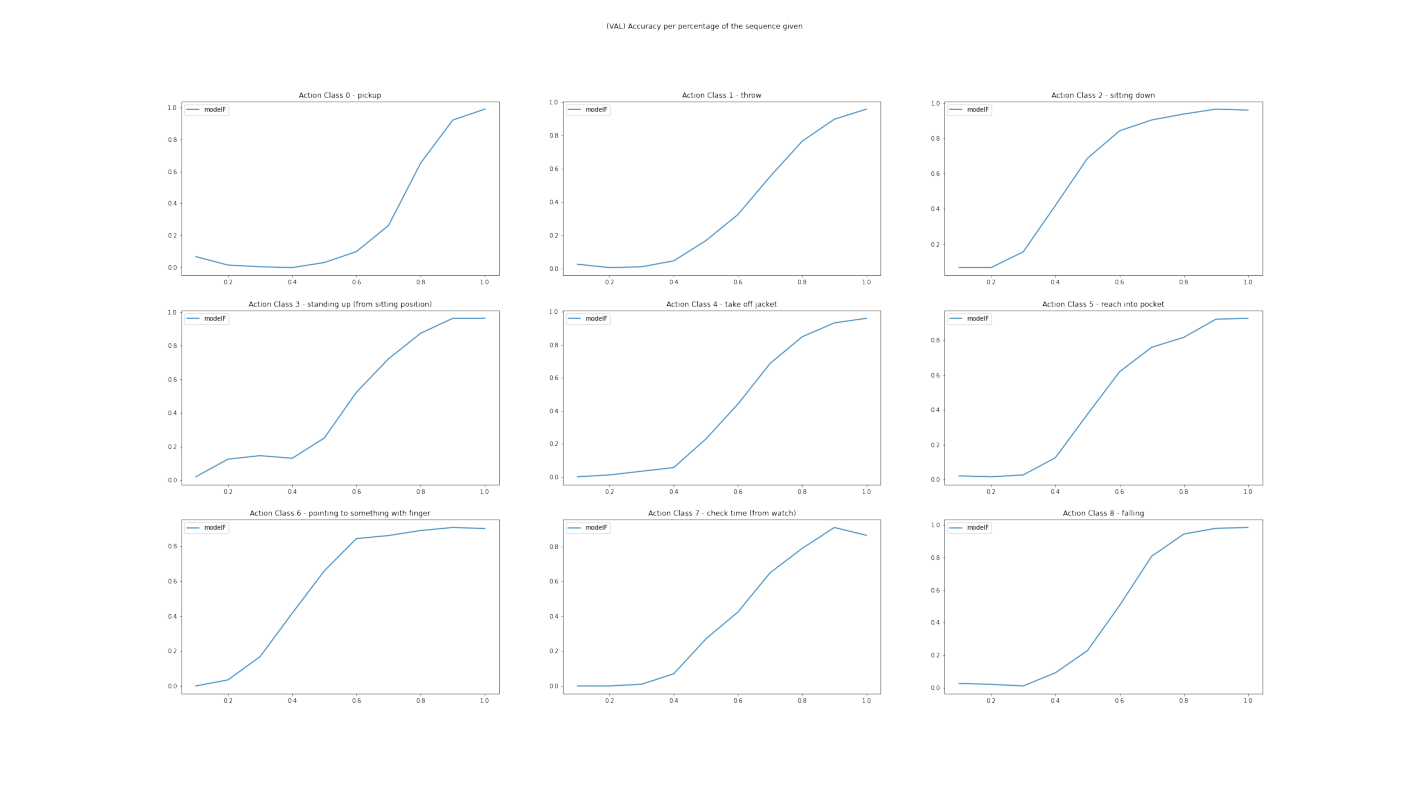

In [304]:
if False:
    
    plt.clf()

    fig, ax = plt.subplots(nrows=3, ncols=3)
    fig.set_figheight(18)
    fig.set_figwidth(32)

    x = np.linspace(start=0.1, stop=1, num=10)

    for i in range(len(classes)):

        ax[i//3][i%3].set_title("Action Class {} - {}".format(i, actions[classes[i]]))
        accuracies = val_results_per_sequence_percentageF[i]
        ax[i//3][i%3].plot(x, accuracies[0], label="modelF")
        ax[i//3][i%3].legend()

    fig.suptitle("(VAL) Accuracy per percentage of the sequence given")
    plt.savefig("./assets/accuracy_per_percentage_valF.png")
    plt.show()

else:

    img = plt.imread("./assets/accuracy_per_percentage_valF.png")
    plt.figure(figsize=(25,32))
    plt.imshow(img)
    plt.axis("off")

#### *3.4.D. On consecutive sequences*

In [312]:
if True:
    train_result_successiveF = [accuracy_successive(model, train_dataset3D, int(0.0075*len(train_dataset3D))) for model in [model_LSTM3DF]]
    val_result_successiveF = [accuracy_successive(model, val_dataset3D, int(0.025*len(val_dataset3D))) for model in [model_LSTM3DF]]

100%|██████████| 42/42 [04:37<00:00,  6.60s/it]


<Figure size 432x288 with 0 Axes>

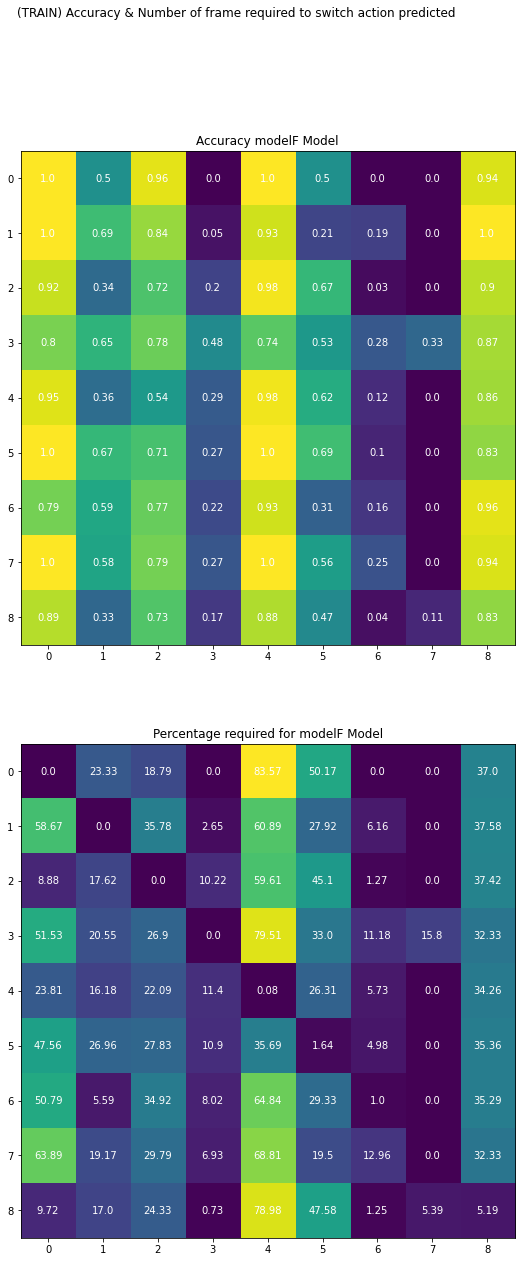

In [317]:
if True:
    
    plt.clf()

    fig, ax = plt.subplots(2)
    fig.set_figheight(20)
    fig.set_figwidth(35)

    x = np.linspace(start=0.1, stop=1, num=10)
    model_names = ["modelF"]

    for i in range(1):

        ax[0].set_title("Accuracy {} Model".format(model_names[i]))
        ax[0].imshow(train_result_successiveF[i][0])
        for j in range(len(classes)):
            for k in range(len(classes)):
                ax[0].text(j, k, round(train_result_successiveF[i][0][k][j],2) , ha="center", va="center", color="w")
        
        ax[1].set_title("Percentage required for {} Model".format(model_names[i]))
        ax[1].imshow(train_result_successiveF[i][1])
        for j in range(len(classes)):
            for k in range(len(classes)):
                ax[1].text(j, k, round(train_result_successiveF[i][1][k][j],2) , ha="center", va="center", color="w")

    fig.suptitle("(TRAIN) Accuracy & Number of frame required to switch action predicted")
    plt.savefig("./assets/accuracy_succesive_trainF.png")
    plt.show()

else:

    img = plt.imread("./assets/accuracy_succesive_trainF.png")
    plt.figure(figsize=(25,32))
    plt.imshow(img)
    plt.axis("off")

<Figure size 432x288 with 0 Axes>

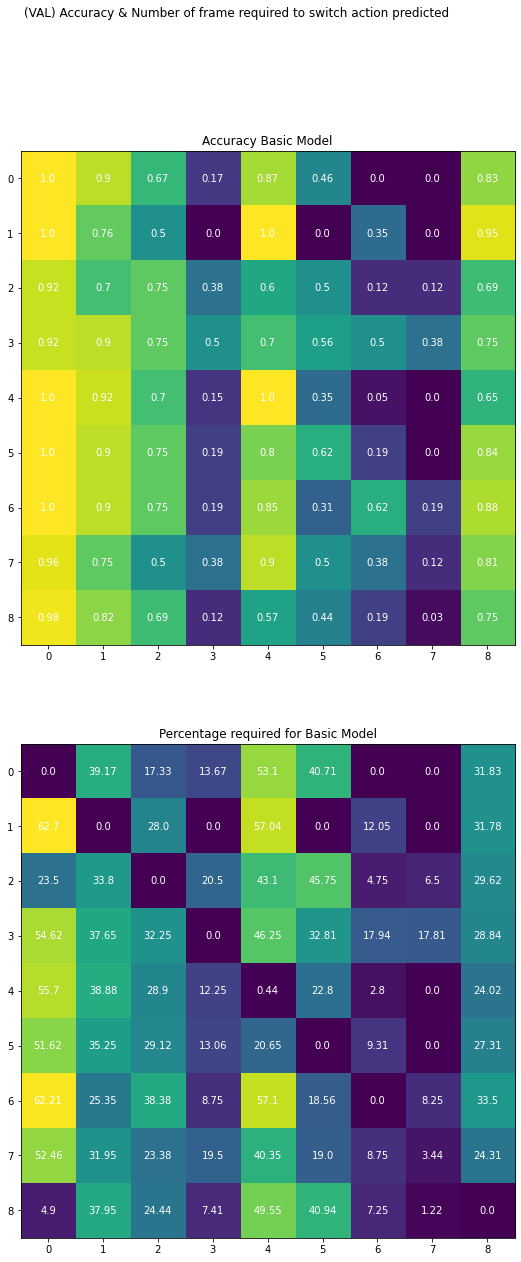

In [319]:
if True:
    
    plt.clf()

    fig, ax = plt.subplots(2)
    fig.set_figheight(20)
    fig.set_figwidth(35)

    x = np.linspace(start=0.1, stop=1, num=10)
    model_names = ["Basic", "Masked", "Part"]

    for i in range(1):

        ax[0].set_title("Accuracy {} Model".format(model_names[i]))
        ax[0].imshow(val_result_successiveF[i][0])
        for j in range(len(classes)):
            for k in range(len(classes)):
                ax[0].text(j, k, round(val_result_successiveF[i][0][k][j],2) , ha="center", va="center", color="w")
        
        ax[1].set_title("Percentage required for {} Model".format(model_names[i]))
        ax[1].imshow(val_result_successiveF[i][1])
        for j in range(len(classes)):
            for k in range(len(classes)):
                ax[1].text(j, k, round(val_result_successiveF[i][1][k][j],2) , ha="center", va="center", color="w")

    fig.suptitle("(VAL) Accuracy & Number of frame required to switch action predicted")
    plt.savefig("./assets/accuracy_succesive_valF.png")
    plt.show()

else:

    img = plt.imread("./assets/accuracy_succesive_valF.png")
    plt.figure(figsize=(25,32))
    plt.imshow(img)
    plt.axis("off")

___

## **4. [EXTRA] THE MODEL (2D DATA)**

___
___